In [1]:
import os
import numpy as np
import random 

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, random_split, Subset, DataLoader
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt

from tqdm import tqdm

/lustre/fswork/projects/rech/tkc/commun/venv/a100/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
class SimpleBlendDataset(Dataset):
    def __init__(self, sample_size, blend_path, iso_path, iso_noisy_path, e1_path, e2_path, redshift_path, rab_path, avg_max_vals_path, augment=False):
        self.total_samples = sample_size  
        self.shape = (self.total_samples, 6, 45, 45)

        self.blend_imgs = np.memmap(blend_path, dtype=np.float32, mode="r", shape=self.shape)
        self.iso_imgs = np.memmap(iso_path, dtype=np.float32, mode="r", shape=self.shape)
        self.iso_imgs_noisy = np.memmap(iso_noisy_path, dtype=np.float32, mode="r", shape=self.shape)

        self.e1 = np.memmap(e1_path, dtype=np.float32, mode="r", shape=(self.total_samples,))
        self.e2 = np.memmap(e2_path, dtype=np.float32, mode="r", shape=(self.total_samples,))
        self.redshift = np.memmap(redshift_path, dtype=np.float32, mode="r", shape=(self.total_samples,))
        self.rab = np.memmap(rab_path, dtype=np.float32, mode="r", shape=(self.total_samples,))

        self.avg_max_vals = np.load(avg_max_vals_path)
        self.augment = augment

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        blend_tensor = torch.from_numpy(self.blend_imgs[idx].copy()).float()
        iso_tensor = torch.from_numpy(self.iso_imgs[idx].copy()).float()
        iso_tensor_noisy = torch.from_numpy(self.iso_imgs_noisy[idx].copy()).float()

        if self.augment:
            if random.random() > 0.5:
                blend_tensor = TF.hflip(blend_tensor)
                iso_tensor_noisy = TF.hflip(iso_tensor_noisy)
            if random.random() > 0.5:
                blend_tensor = TF.vflip(blend_tensor)
                iso_tensor_noisy = TF.vflip(iso_tensor_noisy)
            angle = random.choice([0, 90, 180, 270])
            blend_tensor = TF.rotate(blend_tensor, angle)
            iso_tensor_noisy = TF.rotate(iso_tensor_noisy, angle)

        attributes = torch.tensor([self.redshift[idx], self.e1[idx], self.e2[idx]], dtype=torch.float32)
        return blend_tensor, iso_tensor_noisy, iso_tensor, attributes

In [3]:
def normalize_non_linear(images, avg_max_vals, beta=2.5):
    """Vectorized normalization from Arcelin et al. 2020 (Eq. 4)"""
    scaled = beta * images / avg_max_vals[:, None, None]
    return np.tanh(np.arcsinh(scaled))


def denormalize_non_linear(images_normed, avg_max_vals, beta=2.5):
    """Vectorized inverse normalization."""
    unscaled = np.sinh(np.arctanh(images_normed))
    return unscaled * avg_max_vals[:, None, None] / beta

In [4]:
blend_path = "../scripts/data_generation/sim_lsst_norm_blended.npy"
iso_path = "../scripts/data_generation/sim_lsst_norm_iso.npy"
iso_noisy_path = "../scripts/data_generation/sim_lsst_norm_iso_noisy.npy"
e1_path = "../scripts/data_generation/sim_lsst_e1.npy"
e2_path = "../scripts/data_generation/sim_lsst_e2.npy"
redshift_path = "../scripts/data_generation/sim_lsst_redshift.npy"
rab_path = "../scripts/data_generation/sim_lsst_rab.npy"
avg_max_vals_path = "../scripts/data_generation/sim_lsst_avg_max_vals.npy"

avg_max_vals = np.load(avg_max_vals_path)
sample_size = 200000
dataset = SimpleBlendDataset(sample_size, blend_path, iso_path, iso_noisy_path, e1_path, e2_path, redshift_path, rab_path, avg_max_vals_path)

In [5]:
# Check some samples
print(f"Total samples: {len(dataset)}")
blended, iso_noisy, iso_clean, attrs = dataset[9999]  # First sample
print(f"Image shape: {blended.shape}")  # Should be [6, 45, 45]
print(f"Attributes: {attrs}")  # [redshift, e1, e2]

Total samples: 200000
Image shape: torch.Size([6, 45, 45])
Attributes: tensor([ 0.5506, -0.0078, -0.0049])


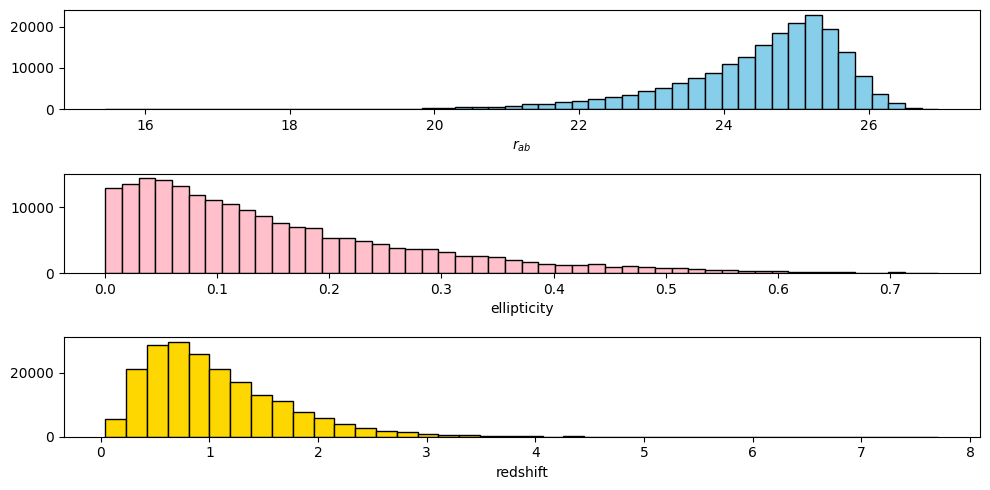

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

e = np.sqrt(dataset.e1**2 + dataset.e2**2)

ax[0].hist(dataset.rab, bins=50, color='skyblue', edgecolor='black')
ax[0].set_xlabel(r"$r_{ab}$")

ax[1].hist(e, bins=50, color='pink', edgecolor='black')
ax[1].set_xlabel("ellipticity")

ax[2].hist(dataset.redshift, bins=40, color='gold', edgecolor='black')
ax[2].set_xlabel("redshift")

plt.tight_layout()
# plt.savefig("images_report/data_distribution.png")

In [11]:
## Select subset with e > 0.1
e_arr = np.sqrt(dataset.e1**2 + dataset.e2**2)
indices = [i for i in range(len(dataset)) if e_arr[i] > 0.1]
filtered_dataset = Subset(dataset, indices)
len(filtered_dataset)

111556

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int = 6, latent_dim: int = 32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=1, padding=1), nn.PReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.PReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.PReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), nn.PReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.PReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1), nn.PReLU(),
            nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.PReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1), nn.PReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(256 * 3 * 3, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        return self.fc_mu(x), self.fc_logvar(x)

class Decoder(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 3 * 3), nn.PReLU()
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.PReLU(),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1), nn.PReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.PReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.PReLU(),
            nn.Conv2d(32, in_channels, 3, padding=1),
            nn.Sigmoid()  # Matches paper output in [0,1]
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 3, 3)
        x = self.conv(x)
        x = F.interpolate(x, size=(45, 45), mode='bilinear', align_corners=False)
        return x

class VAE(nn.Module):
    def __init__(self, in_channels: int = 6, latent_dim: int = 32, beta: float = 0.01):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dim)
        self.decoder = Decoder(in_channels, latent_dim)
        self.latent_dim = latent_dim
        self.beta = beta
    
    def set_beta(self, beta):
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, x, x_hat, mu, logvar):
        recon_loss = F.l1_loss(x_hat, x, reduction='mean')

        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        loss = recon_loss + self.beta * kl
        return {
            'loss': loss,
            'reconstruction_loss': recon_loss,
            'kl_divergence': kl
        }

In [46]:
# Define dummy input
x = torch.randn(1, 6, 45, 45)

# Initialize encoder and decoder
encoder = Encoder(in_channels=6, latent_dim=32)
decoder = Decoder(in_channels=6, latent_dim=32)

# Check shapes through encoder
print("== Encoder ==")
for layer in encoder.conv:
    x = layer(x)
    print(x.shape)

# Save the flattened output
x_flat = x
print(f"Flattened shape: {x_flat.shape}")

# Latent variables
mu = encoder.fc_mu(x_flat)
logvar = encoder.fc_logvar(x_flat)
print(f"mu shape: {mu.shape}, logvar shape: {logvar.shape}")

# Decode
print("\n== Decoder ==")
z = mu  # simulate sampling
x = decoder.fc(z).view(-1, 256, 3, 3)
print(f"After FC reshape: {x.shape}")
for layer in decoder.conv:
    x = layer(x)
    print(x.shape)

== Encoder ==
torch.Size([1, 32, 45, 45])
torch.Size([1, 32, 45, 45])
torch.Size([1, 32, 23, 23])
torch.Size([1, 32, 23, 23])
torch.Size([1, 64, 23, 23])
torch.Size([1, 64, 23, 23])
torch.Size([1, 64, 12, 12])
torch.Size([1, 64, 12, 12])
torch.Size([1, 128, 12, 12])
torch.Size([1, 128, 12, 12])
torch.Size([1, 128, 6, 6])
torch.Size([1, 128, 6, 6])
torch.Size([1, 256, 6, 6])
torch.Size([1, 256, 6, 6])
torch.Size([1, 256, 3, 3])
torch.Size([1, 256, 3, 3])
torch.Size([1, 2304])
Flattened shape: torch.Size([1, 2304])
mu shape: torch.Size([1, 32]), logvar shape: torch.Size([1, 32])

== Decoder ==
After FC reshape: torch.Size([1, 256, 3, 3])
torch.Size([1, 128, 6, 6])
torch.Size([1, 128, 6, 6])
torch.Size([1, 128, 12, 12])
torch.Size([1, 128, 12, 12])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 32, 48, 48])
torch.Size([1, 32, 48, 48])
torch.Size([1, 6, 48, 48])
torch.Size([1, 6, 48, 48])


In [7]:
def train_epoch_iso(vae, device, dataloader, optimizer):
    vae.train()
    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0
    
    # Create progress bar
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for _, iso_noisy, iso_clean, _ in progress_bar:  # only use isolated image
        x = iso_noisy.to(device)
        x_true = iso_clean.to(device)

        x_hat, mu, logvar = vae(x_true)
        loss_dict = vae.loss_function(x_true, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()

        total_loss += loss_dict['loss'].item() * x.size(0)
        total_mse += loss_dict['reconstruction_loss'].item() * x.size(0)
        total_kl += loss_dict['kl_divergence'].item() * x.size(0)
        
        # Update progress bar with current batch stats
        progress_bar.set_postfix({
            'loss': loss_dict['loss'].item(),
            'mse': loss_dict['reconstruction_loss'].item(),
            'kl': loss_dict['kl_divergence'].item()
        })

    n = len(dataloader.dataset)
    progress_bar.close()
    return total_loss / n, total_mse / n, total_kl / n


def val_epoch_iso(vae, device, dataloader, plot=False):
    vae.eval()
    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0

    with torch.no_grad():
        for _, iso_noisy, iso_clean, _ in dataloader:
            x = iso_noisy.to(device)
            x_true = iso_clean.to(device)

            x_hat, mu, logvar = vae(x_true)
            loss_dict = vae.loss_function(x_true, x_hat, mu, logvar)

            total_loss += loss_dict['loss'].item()
            total_mse += loss_dict['reconstruction_loss'].item()
            total_kl += loss_dict['kl_divergence'].item()

    if plot:
        for _ in range(3):
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            i = np.random.randint(0, x.shape[0])
            orig = denormalize_non_linear(x_true[i].cpu().numpy() , avg_max_vals)
            recon = denormalize_non_linear(x_hat[i].cpu().numpy() , avg_max_vals)
            mse = np.mean((recon - orig) ** 2)
            mae = np.mean(np.abs(recon - orig))

            axs[0].imshow(orig[4], cmap="viridis")
            axs[0].set_title("Original")
            axs[0].axis("off")

            axs[1].imshow(recon[4], cmap="viridis")
            axs[1].set_title(f"Recon\nMSE:{mse:.2e}\nMAE:{mae:.2e}")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()

    n = len(dataloader.dataset)
    return total_loss / n, total_mse / n, total_kl / n

def save_checkpoint(epoch, vae, optimizer, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl, checkpoint_path="vae_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_mse': train_mse,
        'train_kl': train_kl, 
        'val_loss': val_loss,
        'val_mse': val_mse,
        'val_kl': val_kl
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

def load_checkpoint(vae, optimizer, checkpoint_path):
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path, weights_only=False)
    else:
        checkpoint = torch.load(checkpoint_path, weights_only=False,map_location=torch.device('cpu'))
    vae.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_mse = checkpoint['train_mse']
    train_kl = checkpoint['train_kl']
    val_loss = checkpoint['val_loss']
    val_mse = checkpoint['val_mse']
    val_kl = checkpoint['val_kl']

    print(f"Checkpoint loaded from epoch {epoch + 1}")
    return epoch, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl

def linear_beta_schedule(epoch, start_beta, final_beta, anneal_epochs):
    if epoch < anneal_epochs:
        t = (epoch + 1) / anneal_epochs
        return start_beta + t * (final_beta - start_beta)
    return final_beta

In [13]:
train_size = int(0.9 * len(filtered_dataset))
val_size = len(filtered_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


Training ...


Training:   0%|          | 0/785 [00:00<?, ?it/s]

Valuating ...


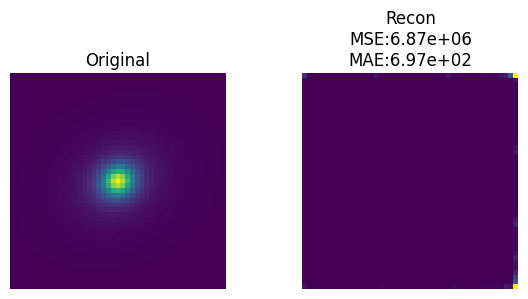

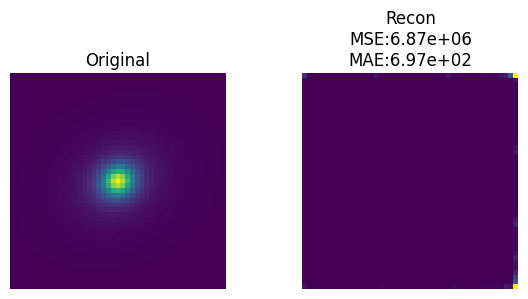

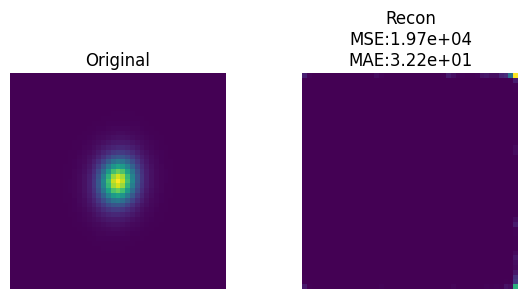


EPOCH 1/40
Train Loss: 6.628e-02 | MSE: 6.475e-02 | KL: 1.523e+00
Val   Loss: 2.778e-04 | MSE: 2.777e-04 | KL: 4.696e-05
Training ...


Valuating ...


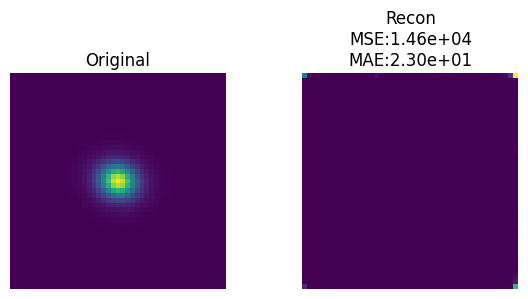

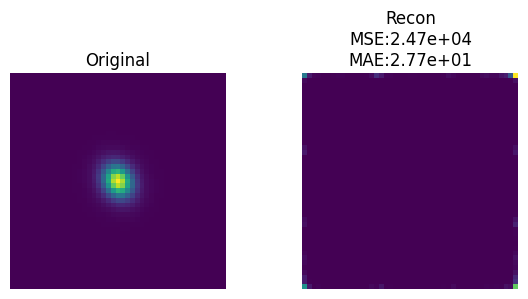

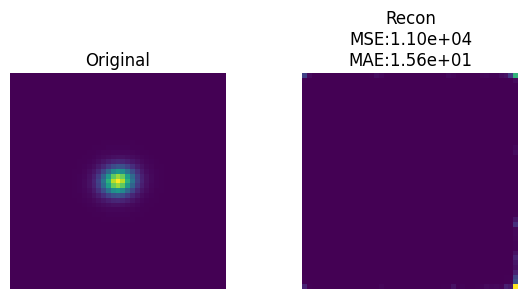


EPOCH 2/40
Train Loss: 3.565e-02 | MSE: 3.565e-02 | KL: 1.992e-03
Val   Loss: 2.772e-04 | MSE: 2.772e-04 | KL: 5.858e-06
Training ...


Valuating ...


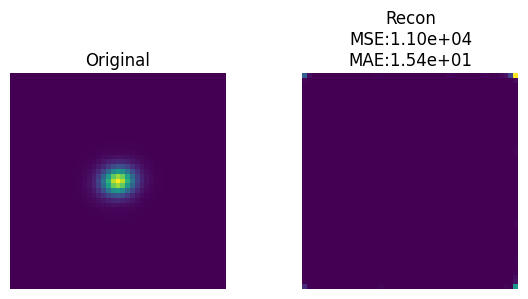

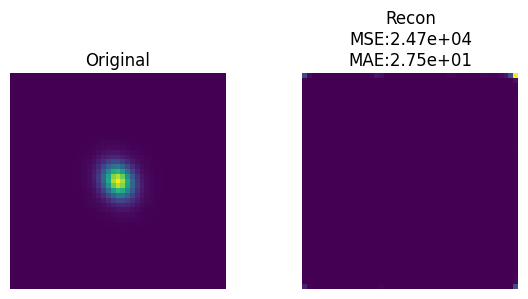

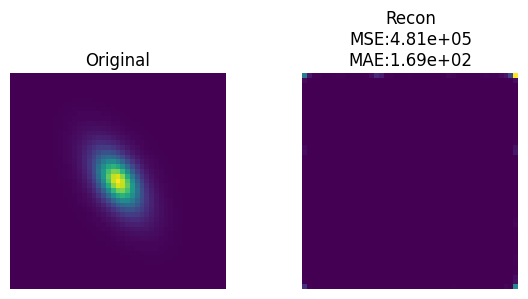


EPOCH 3/40
Train Loss: 3.562e-02 | MSE: 3.562e-02 | KL: 6.751e-04
Val   Loss: 2.771e-04 | MSE: 2.771e-04 | KL: 3.638e-06
Training ...


Valuating ...


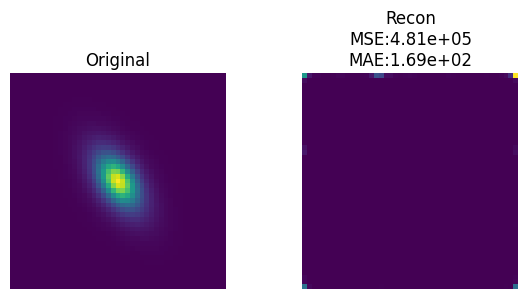

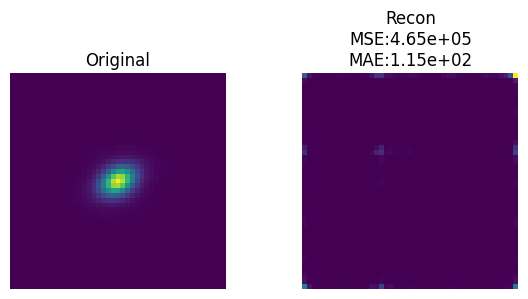

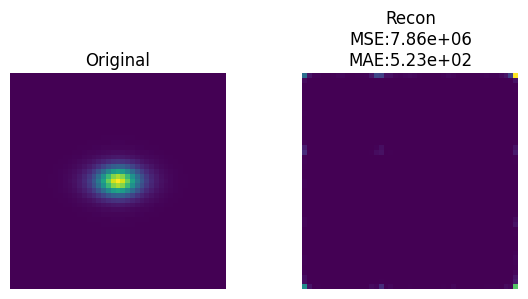


EPOCH 4/40
Train Loss: 3.561e-02 | MSE: 3.561e-02 | KL: 3.423e-04
Val   Loss: 2.769e-04 | MSE: 2.769e-04 | KL: 2.729e-06
Training ...


Valuating ...


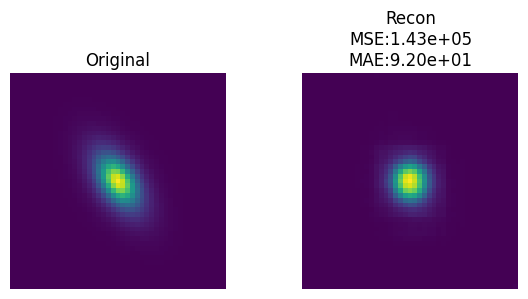

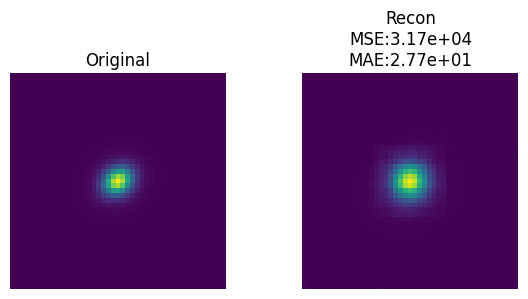

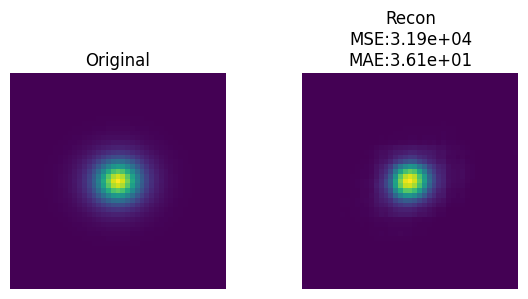


EPOCH 5/40
Train Loss: 2.086e-02 | MSE: 1.904e-02 | KL: 1.815e+00
Val   Loss: 1.203e-04 | MSE: 1.025e-04 | KL: 1.783e-02
Training ...


Valuating ...


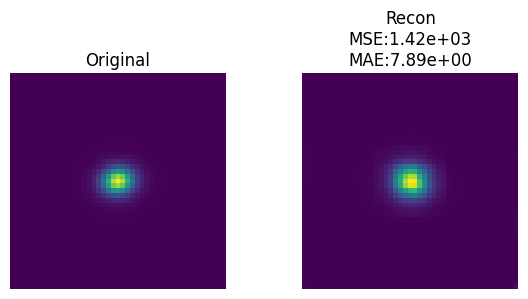

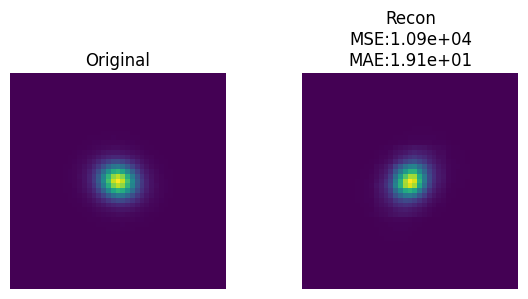

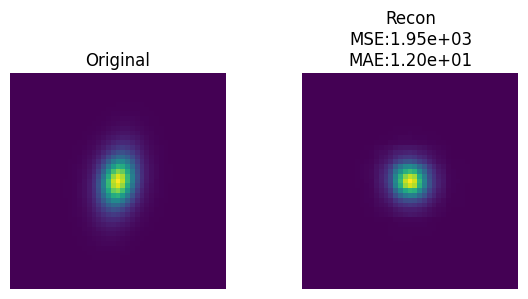


EPOCH 6/40
Train Loss: 1.460e-02 | MSE: 1.229e-02 | KL: 2.304e+00
Val   Loss: 1.112e-04 | MSE: 9.401e-05 | KL: 1.720e-02
Training ...


Valuating ...


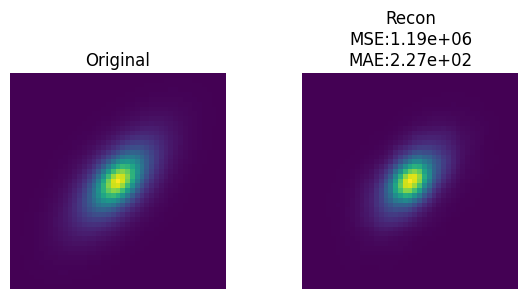

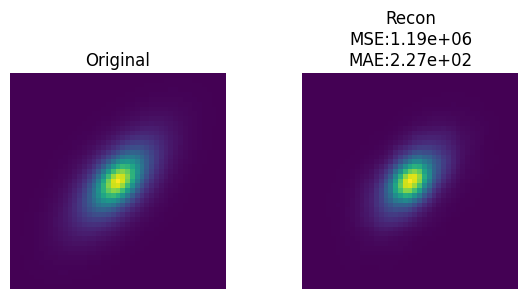

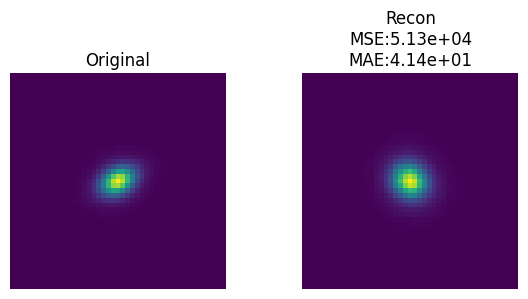


EPOCH 7/40
Train Loss: 1.389e-02 | MSE: 1.153e-02 | KL: 2.360e+00
Val   Loss: 1.069e-04 | MSE: 8.830e-05 | KL: 1.857e-02
Training ...


Valuating ...


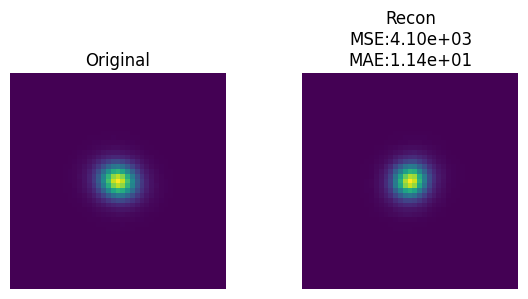

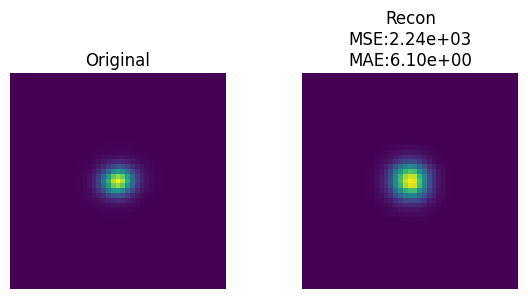

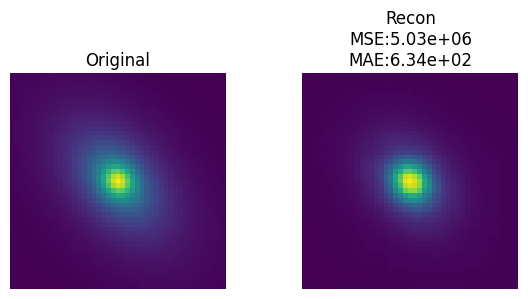


EPOCH 8/40
Train Loss: 1.354e-02 | MSE: 1.114e-02 | KL: 2.398e+00
Val   Loss: 1.054e-04 | MSE: 8.598e-05 | KL: 1.945e-02
Training ...


Valuating ...


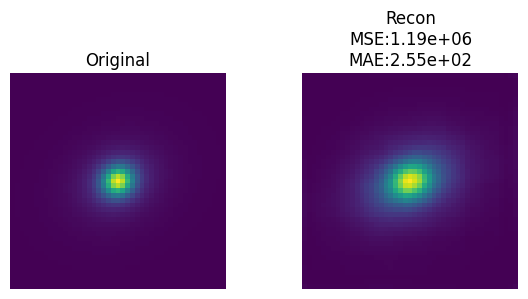

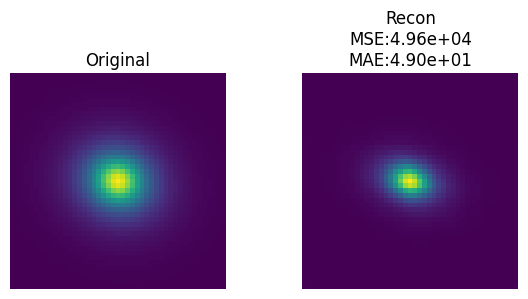

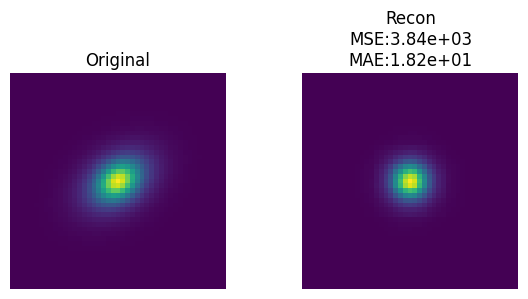


EPOCH 9/40
Train Loss: 1.328e-02 | MSE: 1.081e-02 | KL: 2.471e+00
Val   Loss: 1.037e-04 | MSE: 8.406e-05 | KL: 1.965e-02
Training ...


Valuating ...


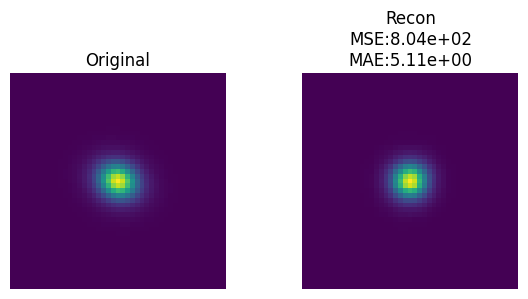

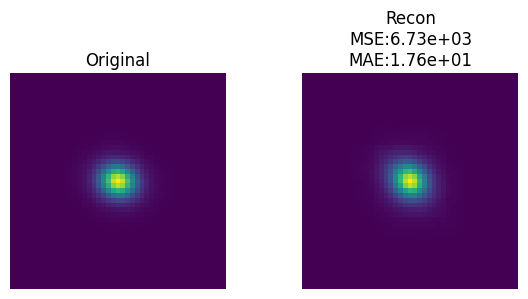

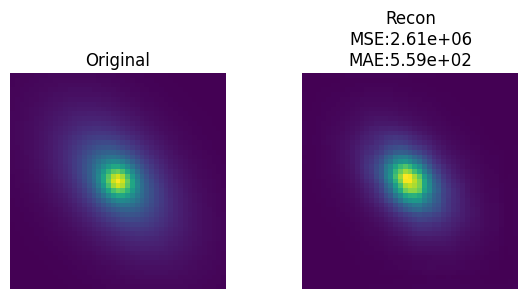


EPOCH 10/40
Train Loss: 1.308e-02 | MSE: 1.051e-02 | KL: 2.569e+00
Val   Loss: 1.018e-04 | MSE: 8.179e-05 | KL: 2.006e-02
Checkpoint saved at epoch 10
Training ...


Valuating ...


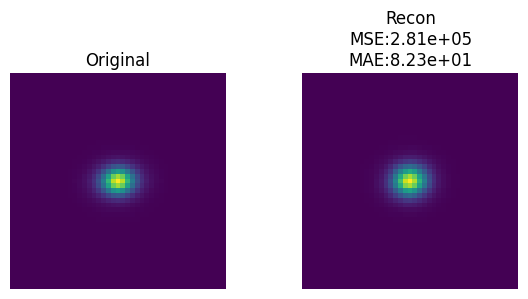

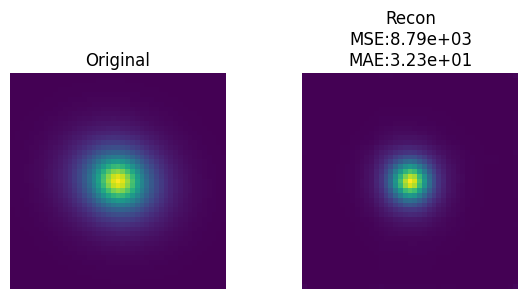

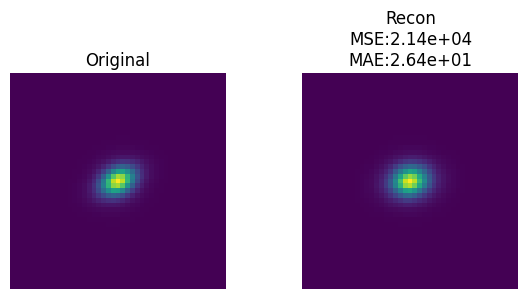


EPOCH 11/40
Train Loss: 1.294e-02 | MSE: 1.030e-02 | KL: 2.633e+00
Val   Loss: 1.010e-04 | MSE: 7.997e-05 | KL: 2.104e-02
Training ...


Valuating ...


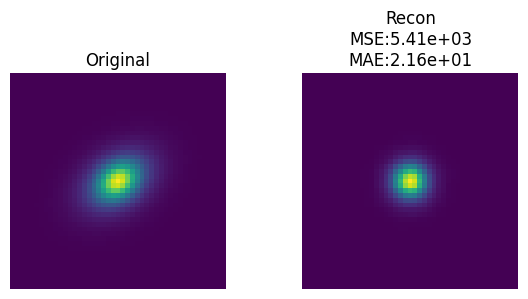

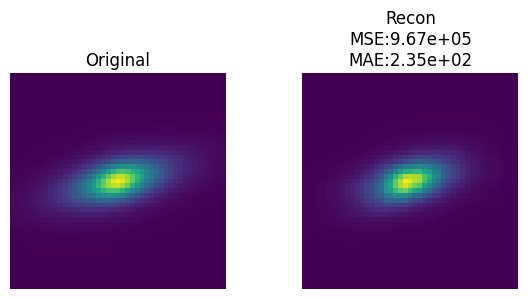

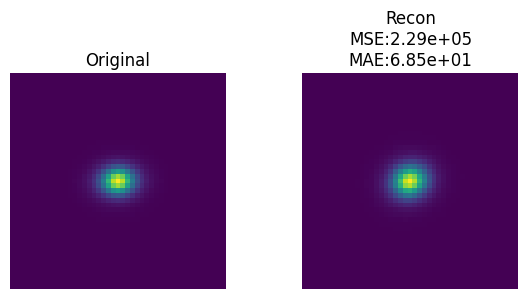


EPOCH 12/40
Train Loss: 1.281e-02 | MSE: 1.012e-02 | KL: 2.690e+00
Val   Loss: 1.004e-04 | MSE: 7.928e-05 | KL: 2.111e-02
Training ...


Valuating ...


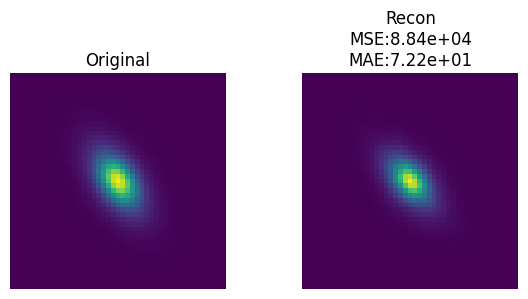

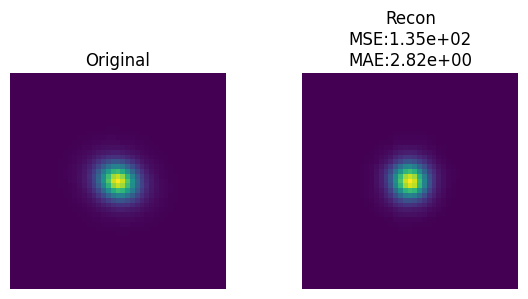

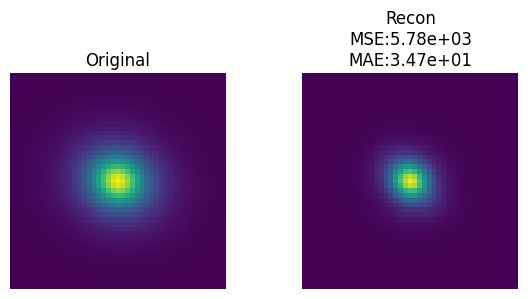


EPOCH 13/40
Train Loss: 1.273e-02 | MSE: 1.002e-02 | KL: 2.708e+00
Val   Loss: 9.971e-05 | MSE: 7.831e-05 | KL: 2.140e-02
Training ...


Valuating ...


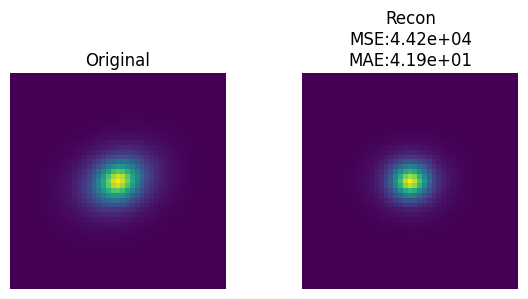

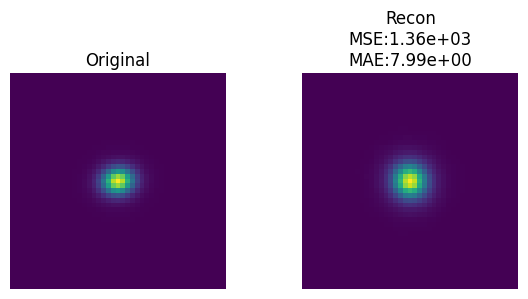

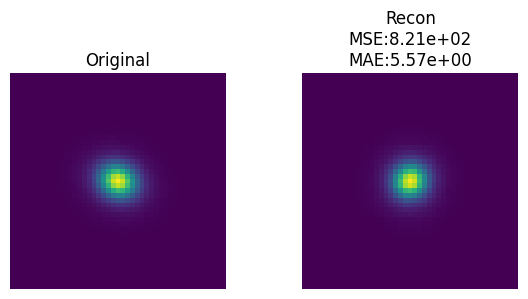


EPOCH 14/40
Train Loss: 1.267e-02 | MSE: 9.948e-03 | KL: 2.718e+00
Val   Loss: 1.001e-04 | MSE: 7.852e-05 | KL: 2.154e-02
Training ...


Valuating ...


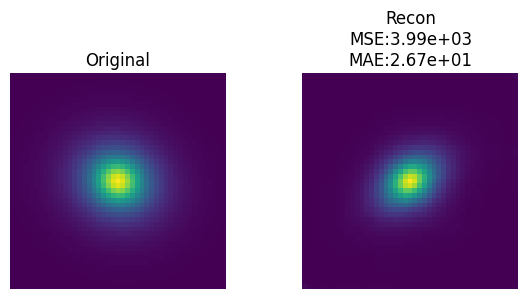

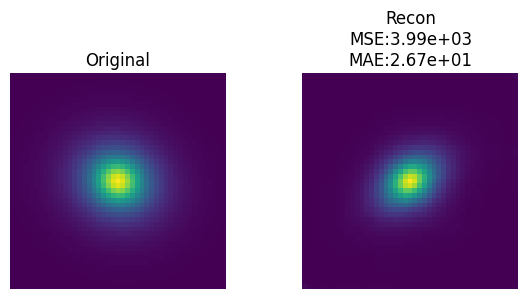

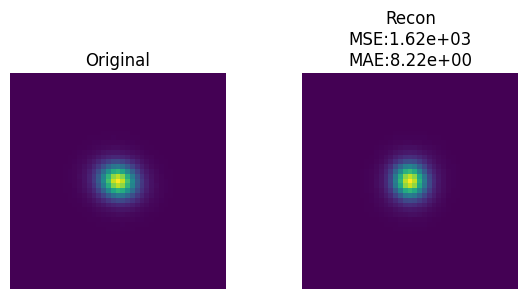


EPOCH 15/40
Train Loss: 1.260e-02 | MSE: 9.889e-03 | KL: 2.716e+00
Val   Loss: 9.968e-05 | MSE: 7.782e-05 | KL: 2.187e-02
Training ...


Valuating ...


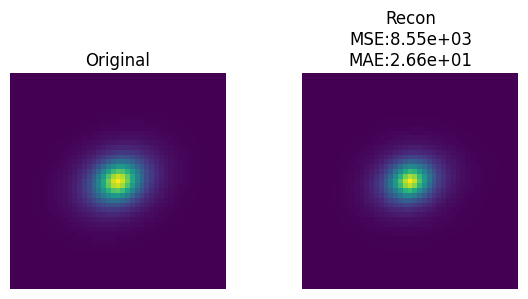

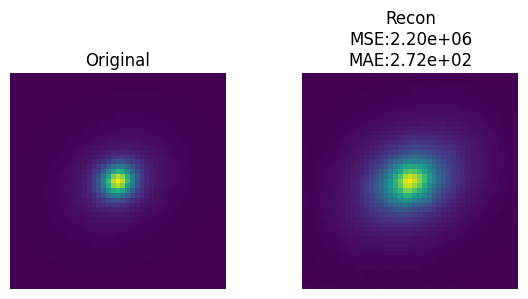

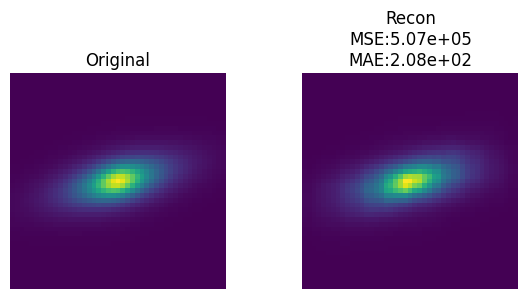


EPOCH 16/40
Train Loss: 1.258e-02 | MSE: 9.855e-03 | KL: 2.724e+00
Val   Loss: 9.824e-05 | MSE: 7.629e-05 | KL: 2.195e-02
Training ...


Valuating ...


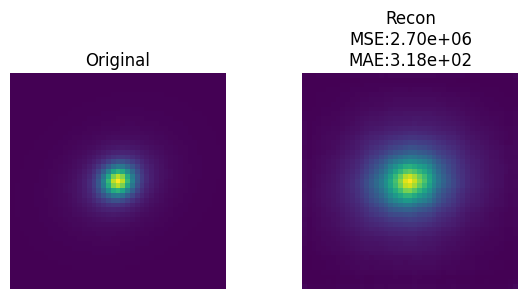

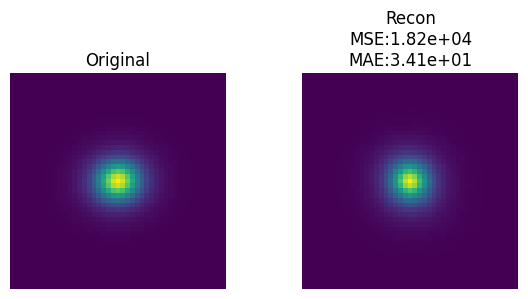

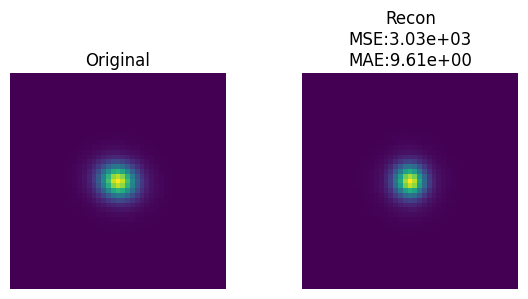


EPOCH 17/40
Train Loss: 1.249e-02 | MSE: 9.730e-03 | KL: 2.756e+00
Val   Loss: 9.772e-05 | MSE: 7.586e-05 | KL: 2.186e-02
Training ...


Valuating ...


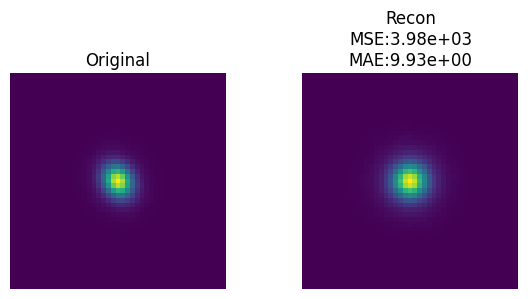

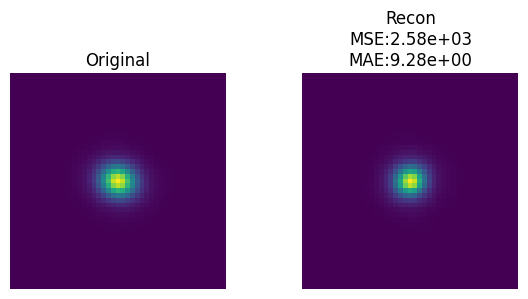

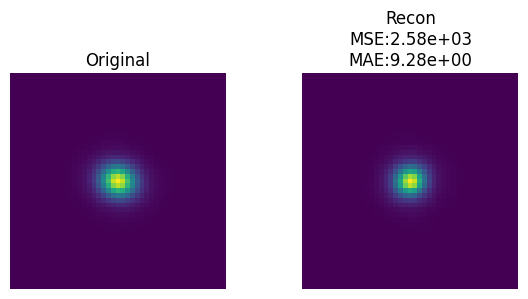


EPOCH 18/40
Train Loss: 1.241e-02 | MSE: 9.607e-03 | KL: 2.808e+00
Val   Loss: 9.680e-05 | MSE: 7.386e-05 | KL: 2.294e-02
Training ...


Valuating ...


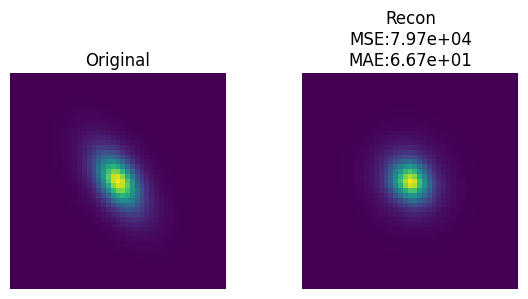

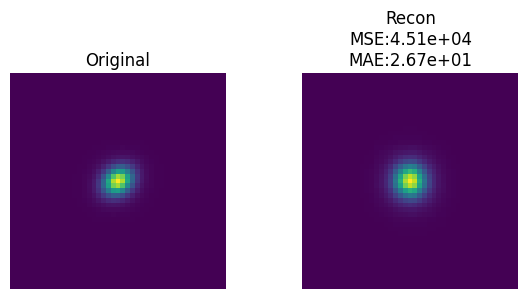

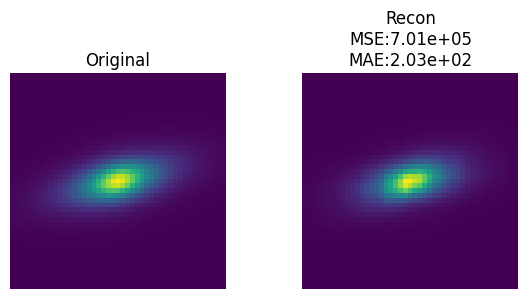


EPOCH 19/40
Train Loss: 1.181e-02 | MSE: 8.642e-03 | KL: 3.170e+00
Val   Loss: 8.948e-05 | MSE: 6.317e-05 | KL: 2.631e-02
Training ...


Valuating ...


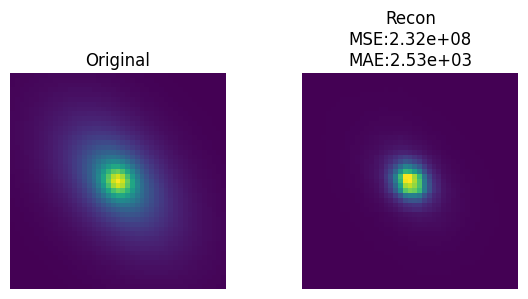

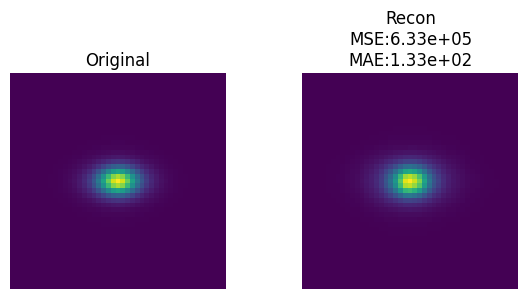

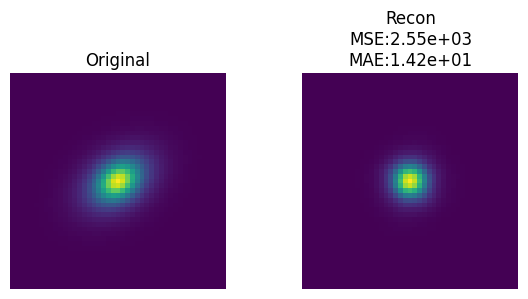


EPOCH 20/40
Train Loss: 1.127e-02 | MSE: 7.890e-03 | KL: 3.379e+00
Val   Loss: 8.897e-05 | MSE: 6.134e-05 | KL: 2.763e-02
Checkpoint saved at epoch 20
Training ...


Valuating ...


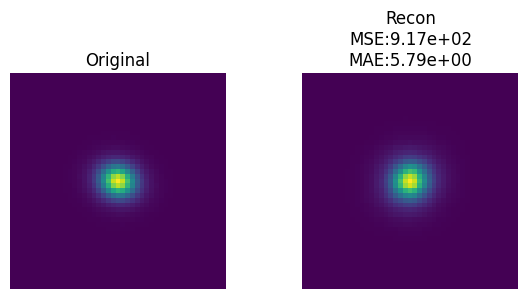

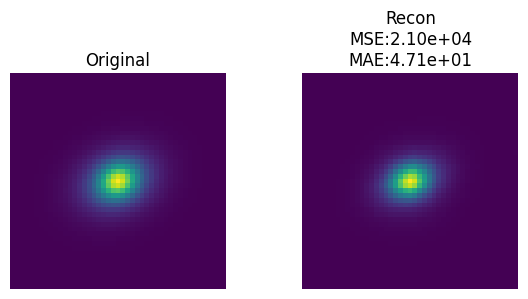

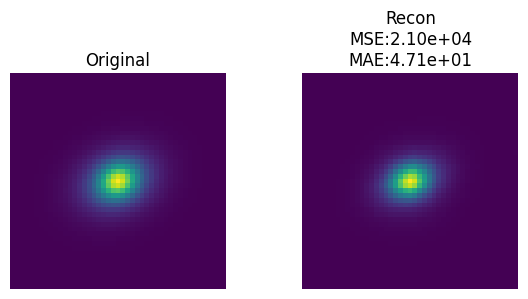


EPOCH 21/40
Train Loss: 1.113e-02 | MSE: 7.712e-03 | KL: 3.420e+00
Val   Loss: 8.678e-05 | MSE: 5.962e-05 | KL: 2.716e-02
Training ...


Valuating ...


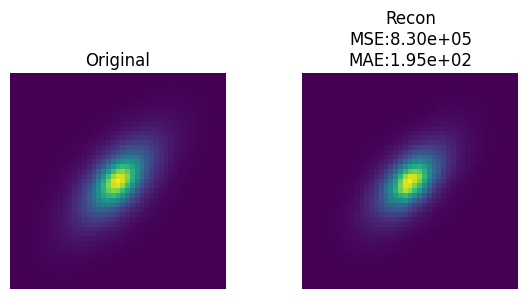

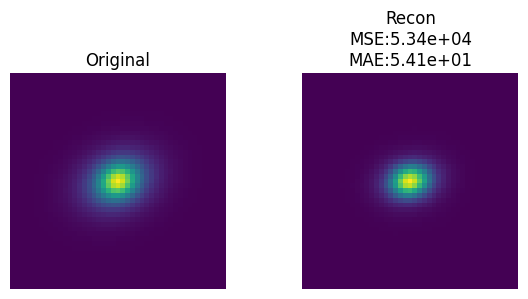

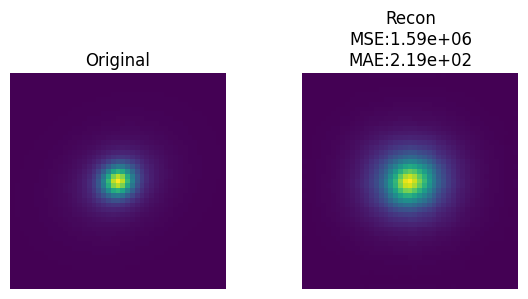


EPOCH 22/40
Train Loss: 1.108e-02 | MSE: 7.643e-03 | KL: 3.434e+00
Val   Loss: 8.620e-05 | MSE: 5.881e-05 | KL: 2.738e-02
Training ...


Valuating ...


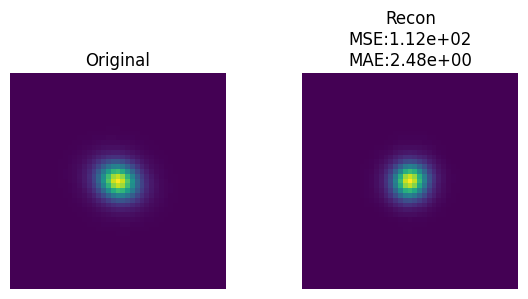

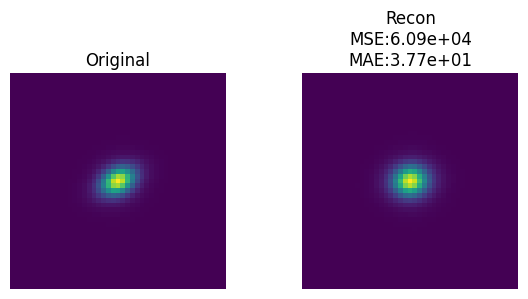

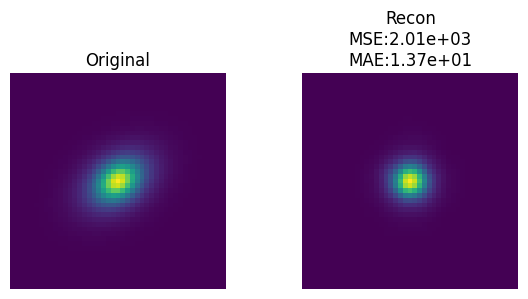


EPOCH 23/40
Train Loss: 1.103e-02 | MSE: 7.582e-03 | KL: 3.450e+00
Val   Loss: 9.050e-05 | MSE: 6.366e-05 | KL: 2.683e-02
Training ...


Valuating ...


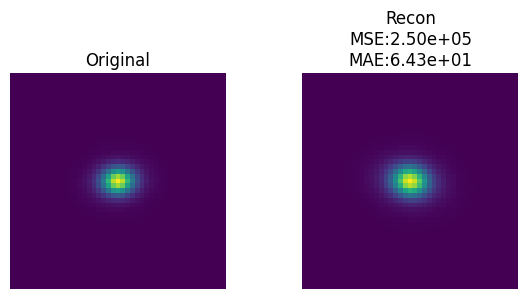

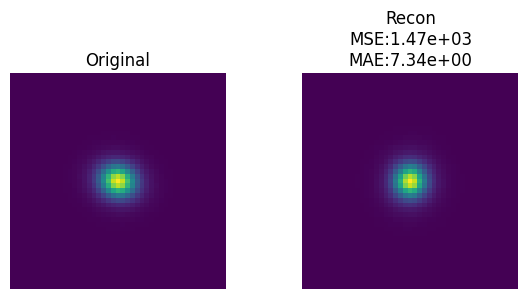

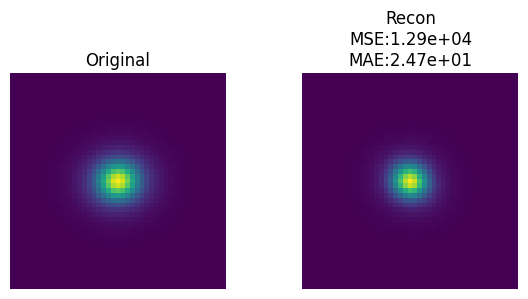


EPOCH 24/40
Train Loss: 1.098e-02 | MSE: 7.518e-03 | KL: 3.459e+00
Val   Loss: 8.524e-05 | MSE: 5.789e-05 | KL: 2.735e-02
Training ...


Valuating ...


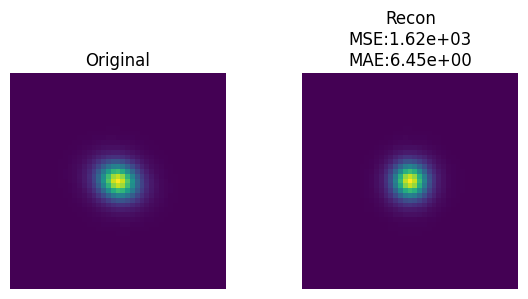

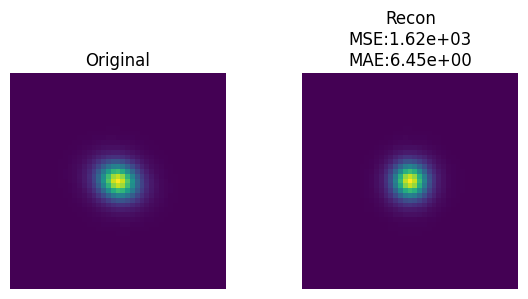

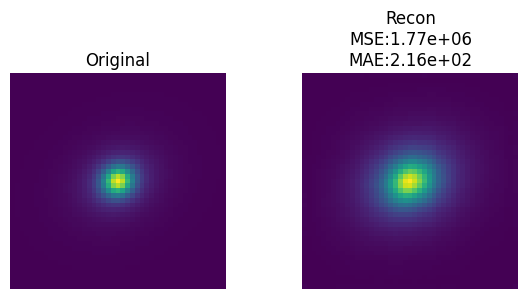


EPOCH 25/40
Train Loss: 1.093e-02 | MSE: 7.443e-03 | KL: 3.487e+00
Val   Loss: 8.644e-05 | MSE: 5.844e-05 | KL: 2.800e-02
Training ...


Valuating ...


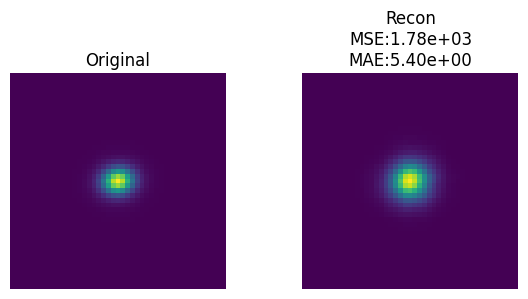

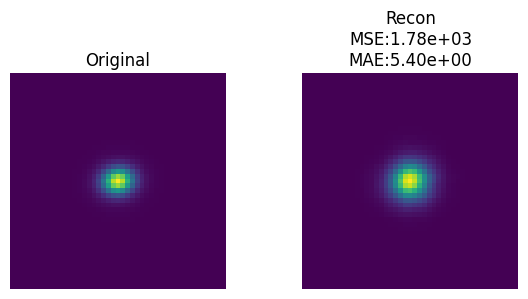

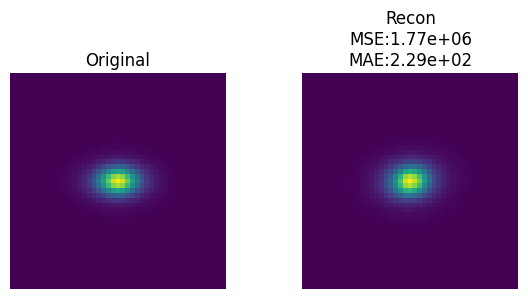


EPOCH 26/40
Train Loss: 1.090e-02 | MSE: 7.412e-03 | KL: 3.493e+00
Val   Loss: 8.638e-05 | MSE: 5.912e-05 | KL: 2.726e-02
Training ...


Valuating ...


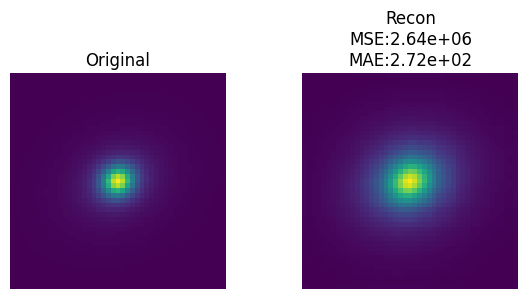

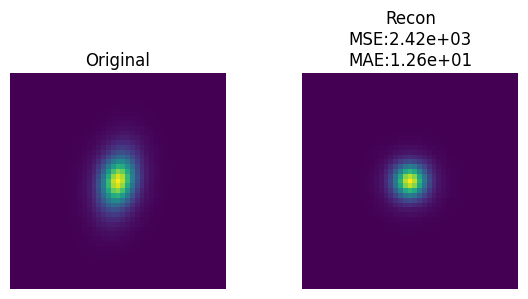

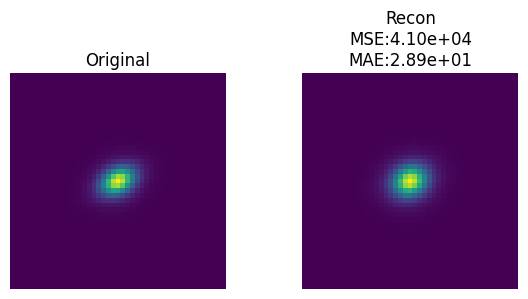


EPOCH 27/40
Train Loss: 1.088e-02 | MSE: 7.380e-03 | KL: 3.502e+00
Val   Loss: 8.570e-05 | MSE: 5.961e-05 | KL: 2.608e-02
Training ...


Valuating ...


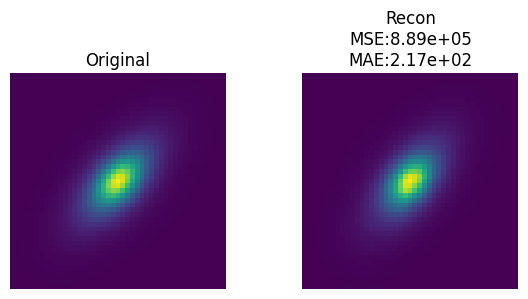

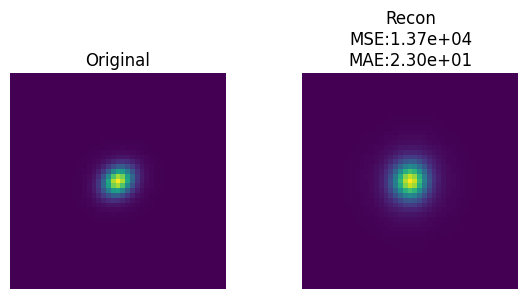

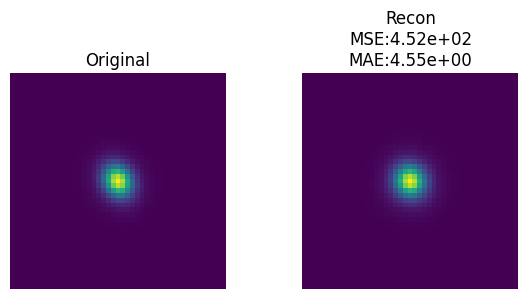


EPOCH 28/40
Train Loss: 1.085e-02 | MSE: 7.345e-03 | KL: 3.509e+00
Val   Loss: 8.680e-05 | MSE: 5.919e-05 | KL: 2.761e-02
Training ...


Valuating ...


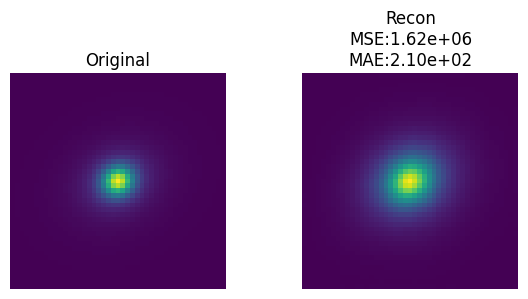

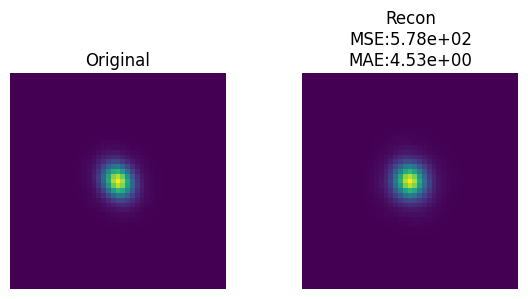

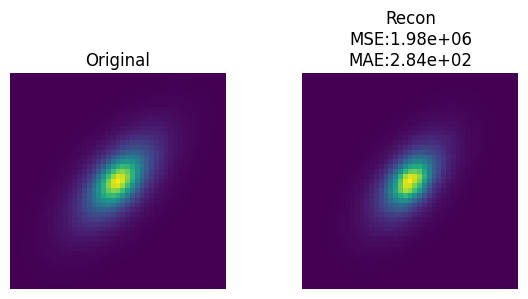


EPOCH 29/40
Train Loss: 1.083e-02 | MSE: 7.302e-03 | KL: 3.528e+00
Val   Loss: 8.458e-05 | MSE: 5.630e-05 | KL: 2.828e-02
Training ...


Valuating ...


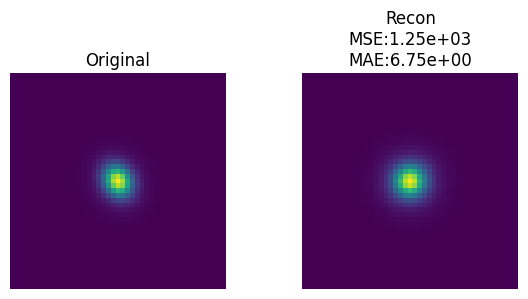

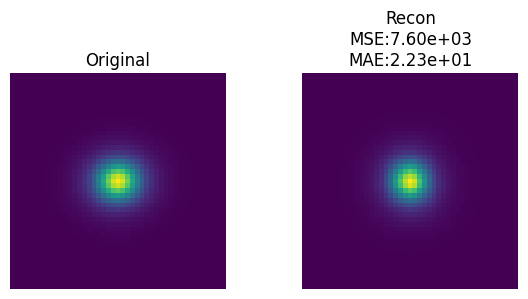

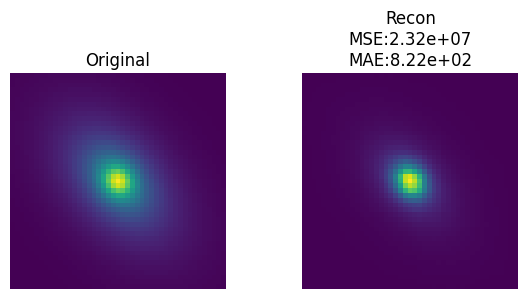


EPOCH 30/40
Train Loss: 1.080e-02 | MSE: 7.266e-03 | KL: 3.539e+00
Val   Loss: 8.420e-05 | MSE: 5.635e-05 | KL: 2.785e-02
Checkpoint saved at epoch 30
Training ...


Valuating ...


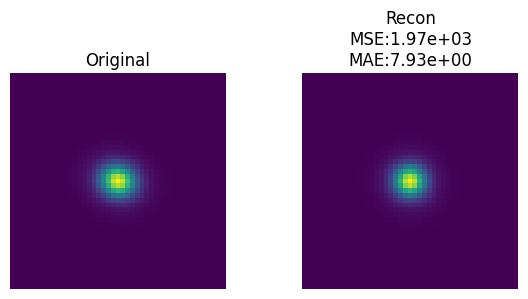

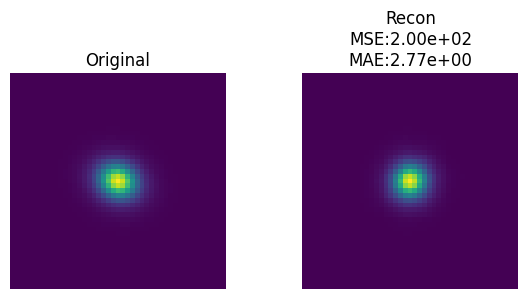

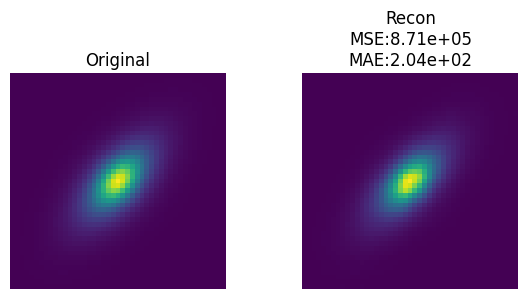


EPOCH 31/40
Train Loss: 1.078e-02 | MSE: 7.208e-03 | KL: 3.567e+00
Val   Loss: 8.502e-05 | MSE: 5.546e-05 | KL: 2.956e-02
Training ...


Valuating ...


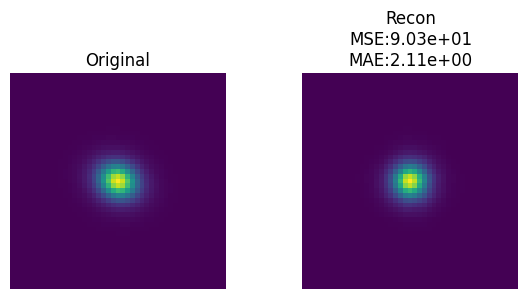

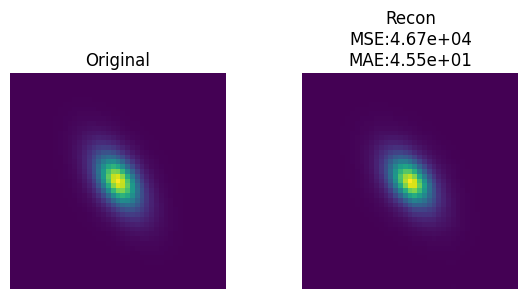

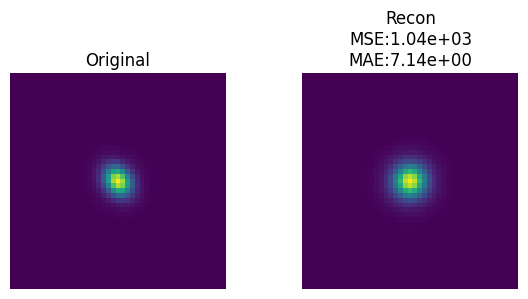


EPOCH 32/40
Train Loss: 1.075e-02 | MSE: 7.135e-03 | KL: 3.610e+00
Val   Loss: 8.354e-05 | MSE: 5.548e-05 | KL: 2.806e-02
Training ...


Valuating ...


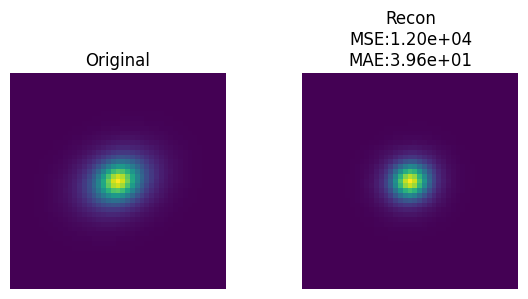

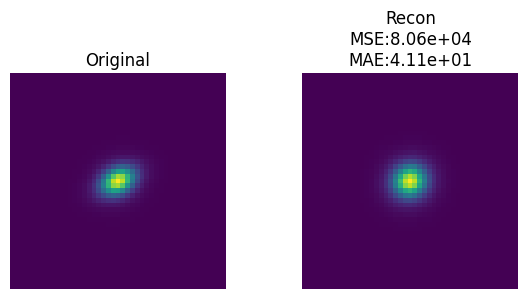

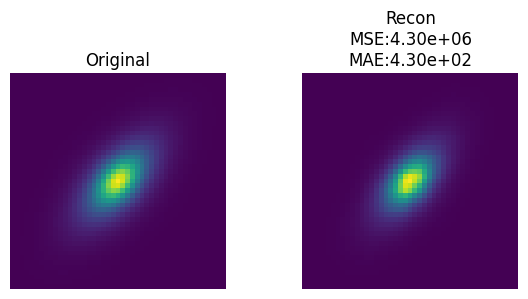


EPOCH 33/40
Train Loss: 1.071e-02 | MSE: 7.054e-03 | KL: 3.652e+00
Val   Loss: 8.343e-05 | MSE: 5.444e-05 | KL: 2.899e-02
Training ...


Valuating ...


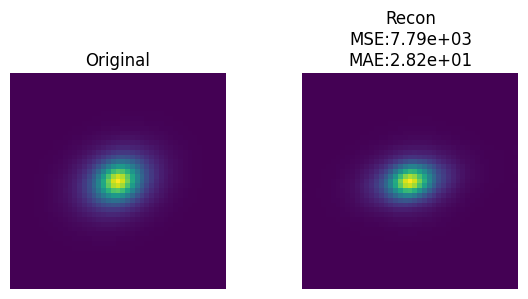

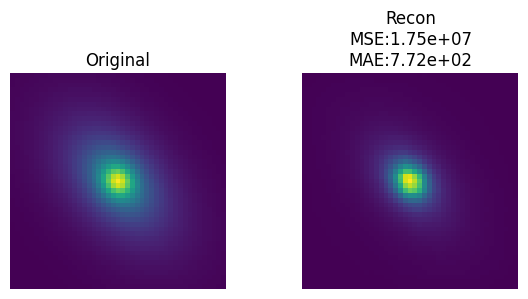

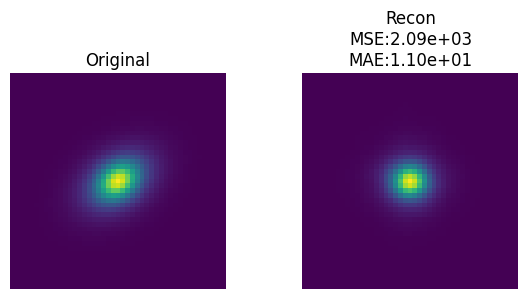


EPOCH 34/40
Train Loss: 1.067e-02 | MSE: 6.989e-03 | KL: 3.683e+00
Val   Loss: 8.392e-05 | MSE: 5.377e-05 | KL: 3.015e-02
Training ...


Valuating ...


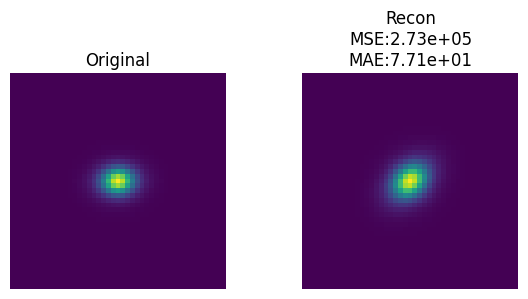

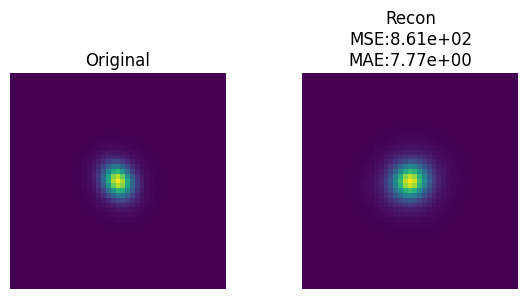

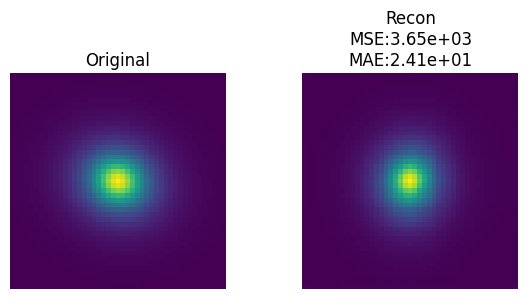


EPOCH 35/40
Train Loss: 1.063e-02 | MSE: 6.910e-03 | KL: 3.720e+00
Val   Loss: 8.339e-05 | MSE: 5.443e-05 | KL: 2.896e-02
Training ...


Valuating ...


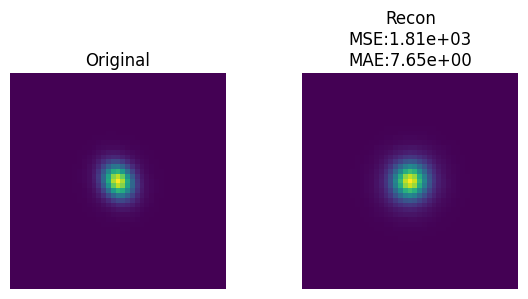

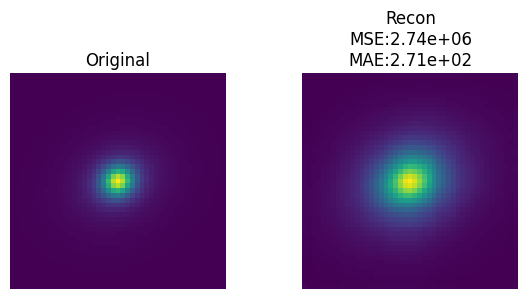

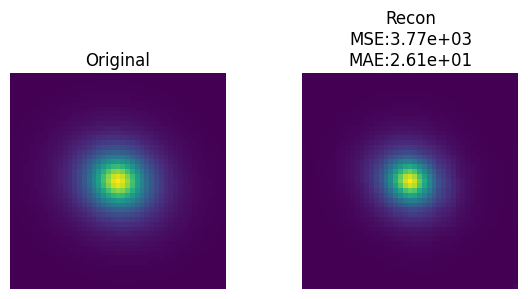


EPOCH 36/40
Train Loss: 1.063e-02 | MSE: 6.910e-03 | KL: 3.717e+00
Val   Loss: 8.327e-05 | MSE: 5.319e-05 | KL: 3.008e-02
Training ...


Valuating ...


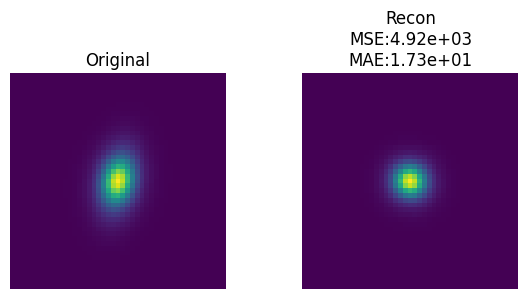

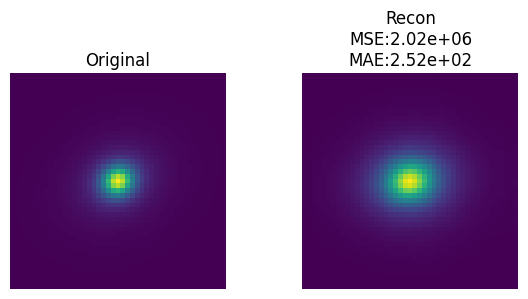

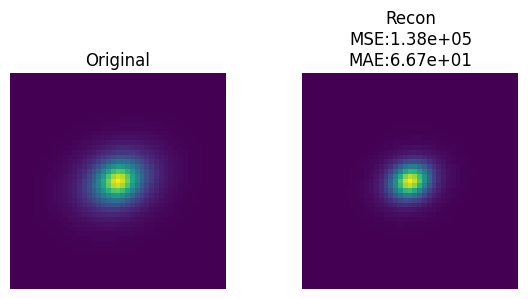


EPOCH 37/40
Train Loss: 1.058e-02 | MSE: 6.839e-03 | KL: 3.744e+00
Val   Loss: 8.414e-05 | MSE: 5.516e-05 | KL: 2.898e-02
Training ...


Valuating ...


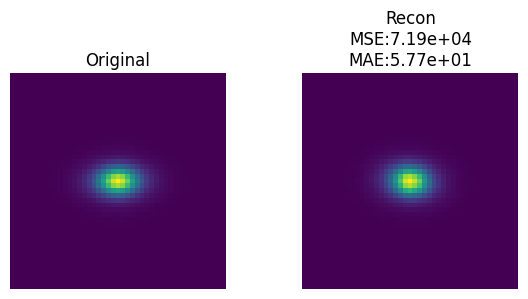

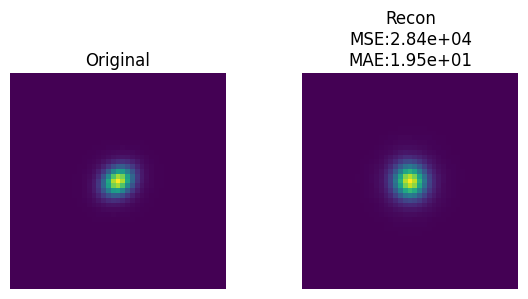

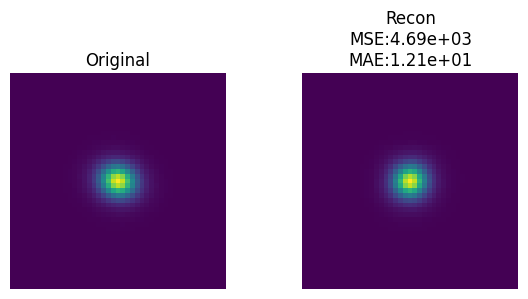


EPOCH 38/40
Train Loss: 1.056e-02 | MSE: 6.784e-03 | KL: 3.780e+00
Val   Loss: 8.424e-05 | MSE: 5.413e-05 | KL: 3.011e-02
Training ...


Valuating ...


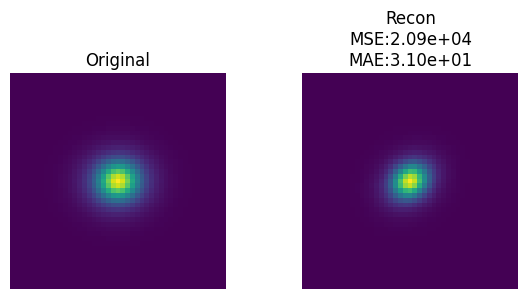

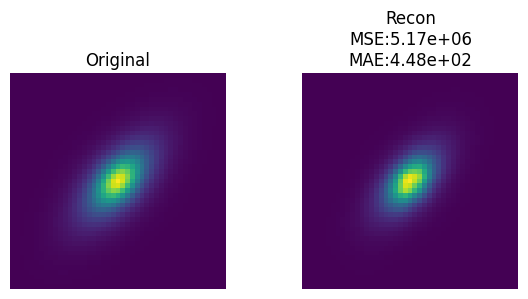

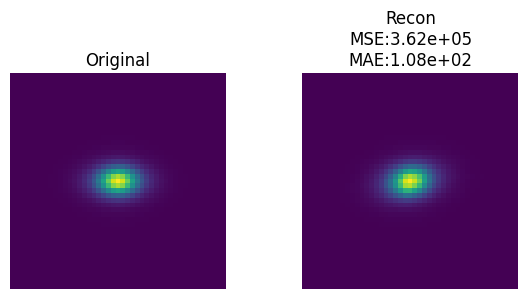


EPOCH 39/40
Train Loss: 1.050e-02 | MSE: 6.677e-03 | KL: 3.822e+00
Val   Loss: 8.345e-05 | MSE: 5.338e-05 | KL: 3.008e-02
Training ...


Valuating ...


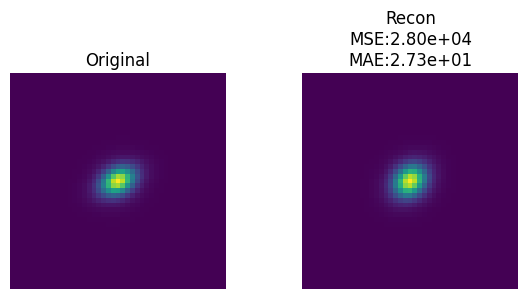

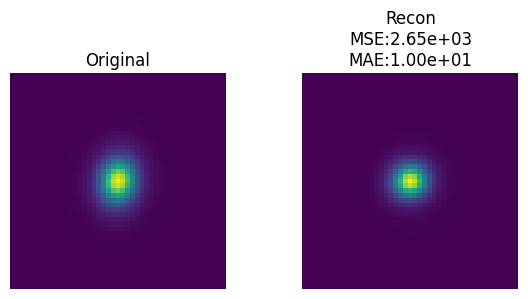

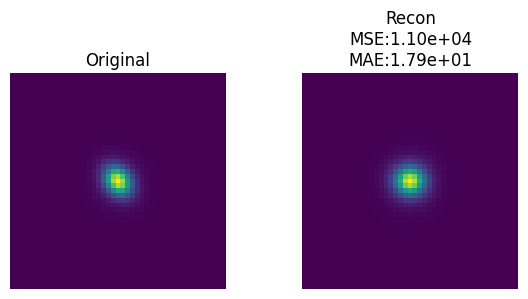


EPOCH 40/40
Train Loss: 1.048e-02 | MSE: 6.651e-03 | KL: 3.827e+00
Val   Loss: 8.262e-05 | MSE: 5.205e-05 | KL: 3.057e-02
Checkpoint saved at epoch 40


In [15]:
# --- Initialize Model ---
torch.manual_seed(42)
latent_dims = 32
epoch = 0
vae = VAE(latent_dim=latent_dims, beta = 1e-3)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)

vae.to(device)

# --- Training Loop ---
num_epochs = 40
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Reset checkpoint file
checkpoint_path = "checkpoints/test.pth"

for epoch in range(num_epochs):
    # beta = linear_beta_schedule(epoch, 0, 1e-3, 20)
    # print(f"Beta = {beta:.2e}")
    # vae.set_beta(beta)
    vae.set_beta(1e-3)
    print("Training ...")
    train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch_iso(vae, device, train_loader, optimizer)
    print("Valuating ...")
    val_loss[epoch], val_mse[epoch], val_kl[epoch] = val_epoch_iso(vae, device, val_loader, plot=True)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e} | MSE: {train_mse[epoch]:.3e} | KL: {train_kl[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e} | MSE: {val_mse[epoch]:.3e} | KL: {val_kl[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, vae, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1], checkpoint_path=checkpoint_path)

In [11]:
vae = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
checkpoint_path = "checkpoints/vae_checkpoint_1e-3.pth"

epoch, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl = load_checkpoint(vae, optimizer, checkpoint_path)

Checkpoint loaded from epoch 40


In [12]:
def plot_loss_function(num_epochs, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl, name):
    fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

    epochs = np.arange(1, num_epochs + 1)

    # Train Loss Plot
    ax.plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-", linewidth=3)
    ax.plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-", linewidth=3)

    ax.plot(epochs, train_mse, label="Train MSE", color="cyan", linestyle="--")
    ax.plot(epochs, val_mse, label="Val MSE", color="orange", linestyle="--")

    ax.plot(epochs, train_kl, label="Train KL", color="limegreen", linestyle="--")
    ax.plot(epochs, val_kl, label="Val KL", color="gold", linestyle="--")

    ax.set_xlabel("Epochs", fontsize=11)
    ax.set_ylabel("Loss", fontsize=11)
    ax.set_yscale("log")  # Set log scale
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

    # Validation Loss Plot
    plt.tight_layout()
    # plt.savefig(f"images_report/{name}")
    plt.show()

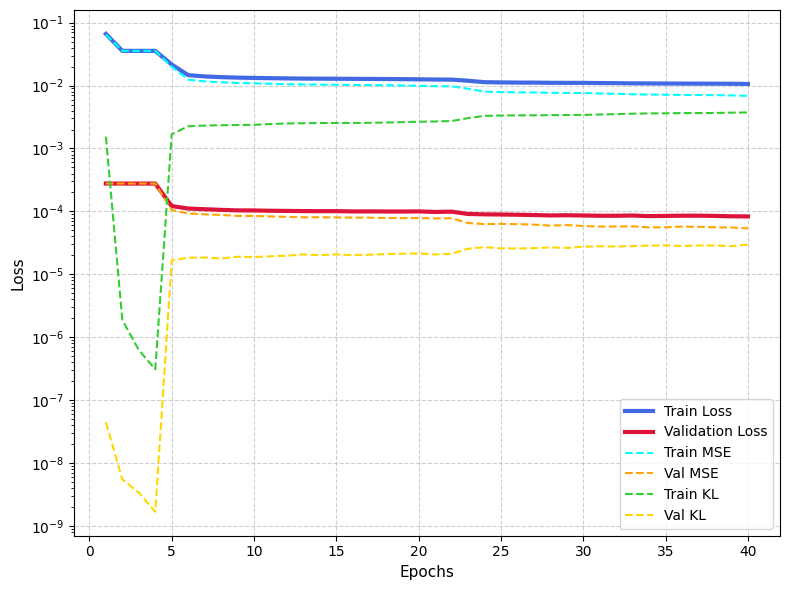

In [17]:
num_epochs = epoch + 1
plot_loss_function(num_epochs, train_loss, train_mse, train_kl * 1e-3, val_loss, val_mse, val_kl * 1e-3, "loss_function_t1_vae_beta_1e-3")

In [12]:
def show_random_reconstructions(vae, dataset, device, avg_max_vals, n_samples=5, name="test"):
    vae.eval()
    fig, axs = plt.subplots(n_samples, 3, figsize=(9, 3 * n_samples))
    
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx][1].unsqueeze(0).to(device)  # shape [1, 1, 45, 45]
        with torch.no_grad():
            recon, mu, log_var = vae(img)

        img = img.squeeze().cpu().numpy()
        recon = recon.squeeze().cpu().numpy()
        res = img - recon
        
        img_ = denormalize_non_linear(img, avg_max_vals)
        recon_ = denormalize_non_linear(recon, avg_max_vals)
        res_ = denormalize_non_linear(res, avg_max_vals)

        im0 = axs[i, 0].imshow(img_[2], cmap='viridis')
        axs[i, 0].set_title(f"Original (idx {idx})")
        axs[i, 0].axis('off')
        fig.colorbar(im0, ax=axs[i, 0], fraction=0.046, pad=0.04)

        im1 = axs[i, 1].imshow(recon_[2], cmap='viridis')
        axs[i, 1].set_title(f"Reconstruction")
        axs[i, 1].axis('off')
        fig.colorbar(im1, ax=axs[i, 1], fraction=0.046, pad=0.04)

        im2 = axs[i, 2].imshow(res_[2], cmap='viridis')
        axs[i, 2].set_title(f"Residual")
        axs[i, 2].axis('off')
        fig.colorbar(im2, ax=axs[i, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.savefig(f"images_report/{name}")


/tmp/ipykernel_2305454/3193383021.py:9: RuntimeWarning: invalid value encountered in arctanh
  unscaled = np.sinh(np.arctanh(images_normed))


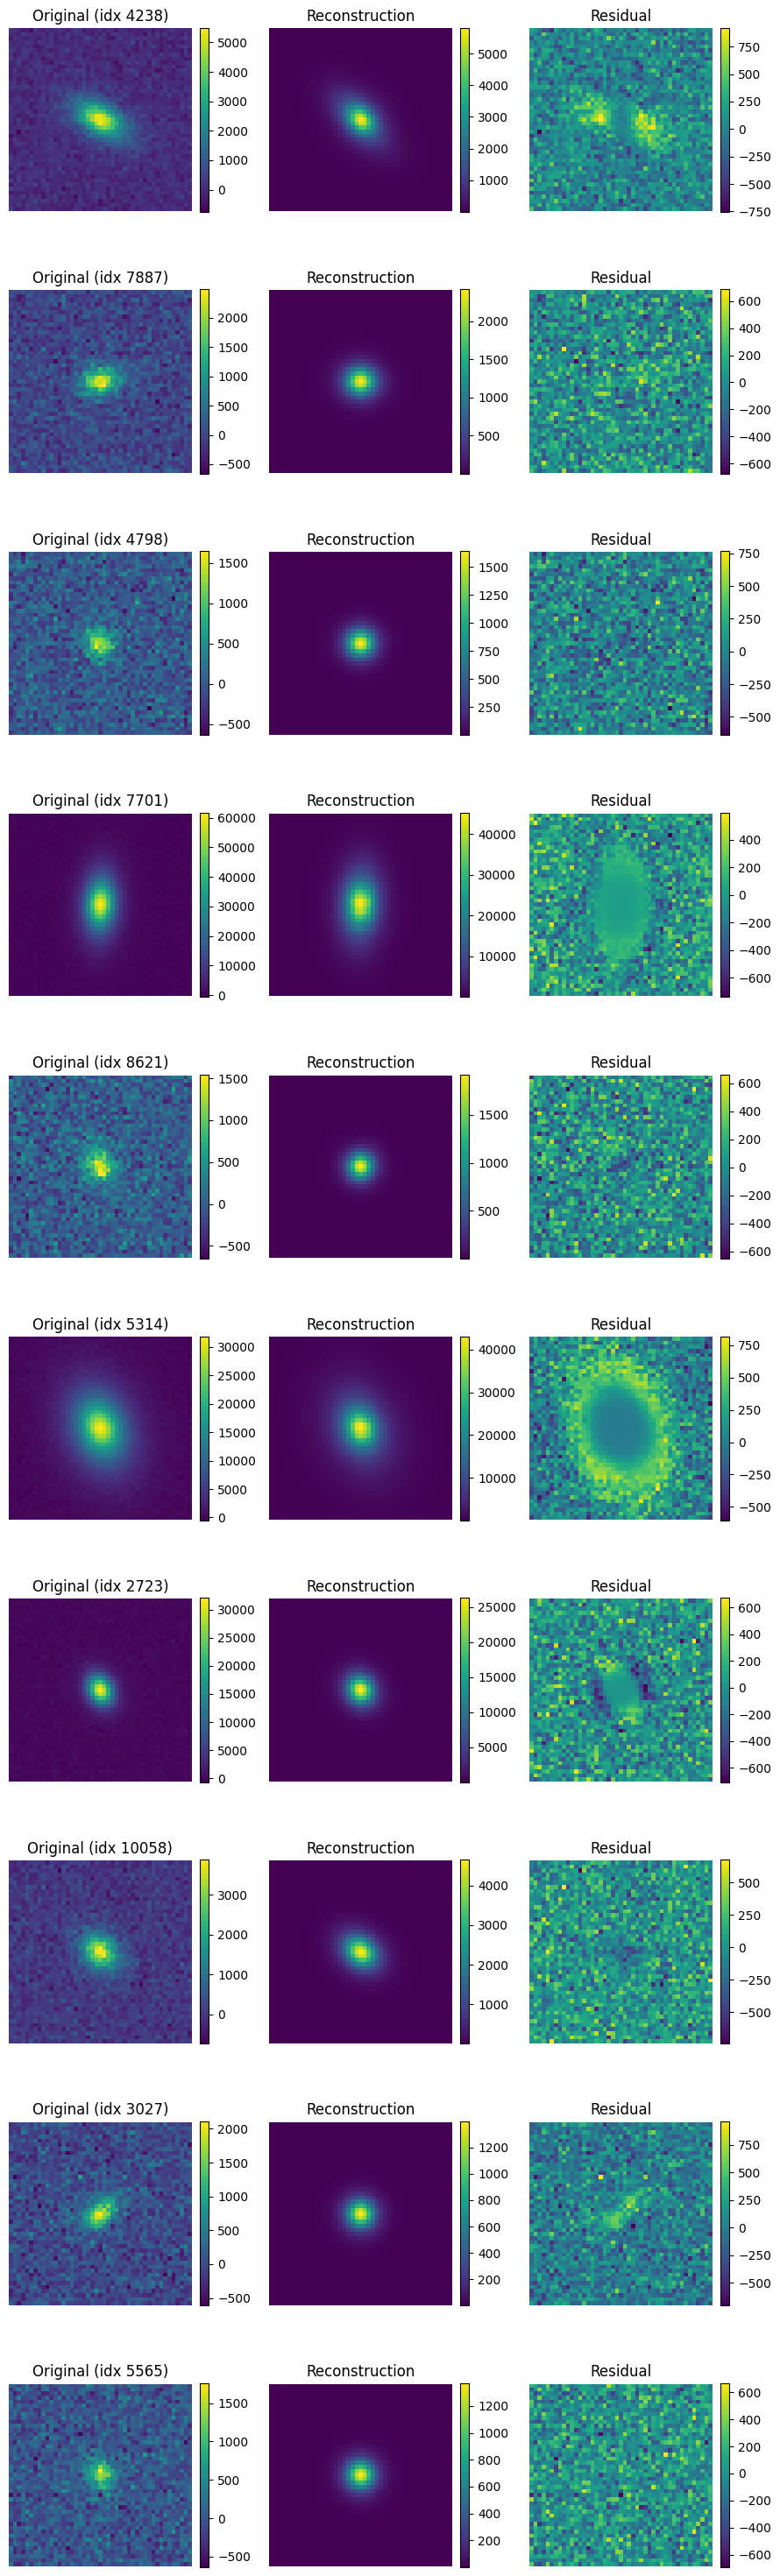

In [87]:
show_random_reconstructions(vae, val_dataset, device, avg_max_vals, n_samples=10, name="recon_t1_vaeclean_beta_1e-3_iso_noise")

### SSIM

In [13]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity 
from scipy import stats

In [17]:
def calculate_and_plot_ssim(vae, dataset, device, n_samples=10, show_images=True):
    vae.eval()
    ssim_values = []
    cosine_values = []

    fig, axs = plt.subplots(n_samples, 2, figsize=(6, 2 * n_samples)) if show_images else (None, None)

    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset)) 
        img = dataset[idx][0].unsqueeze(0).to(device)  # Input image
        img_ = dataset[idx][2].cpu().numpy()  # [band, H, W]
        
        with torch.no_grad():
            recon, _, _ = vae(img)
        recon_ = recon.squeeze().cpu().numpy()

        # Use only one band for SSIM, e.g. band r
        ssim_val = ssim(img_[2], recon_[2], data_range=img_[2].max() - img_[2].min())
        ssim_values.append(ssim_val)

        # Flatten images for cosine similarity
        orig_vec = img_[2].flatten().reshape(1, -1)  # shape (1, N)
        recon_vec = recon_[2].flatten().reshape(1, -1)

        cos_val = cosine_similarity(orig_vec, recon_vec)[0][0]
        cosine_values.append(cos_val)

        if show_images:
            axs[i, 0].imshow(img_[2], cmap='gray')
            axs[i, 0].set_title(f"Original (idx={idx})")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(recon_[2], cmap='gray')
            axs[i, 1].set_title(f"Reconstruction\nSSIM={ssim_val:.4f}")
            axs[i, 1].axis('off')

    if show_images:
        plt.tight_layout()
        plt.show()

    return ssim_values, cosine_values

In [20]:
ssim_values_t1, cosine_values_t1 = calculate_and_plot_ssim(vae, dataset, device, n_samples=1000, show_images=False)

In [21]:
# Calculate mean
mean_ssim_t1 = np.mean(ssim_values_t1)
mean_cos_t1 = np.mean(cosine_values_t1)

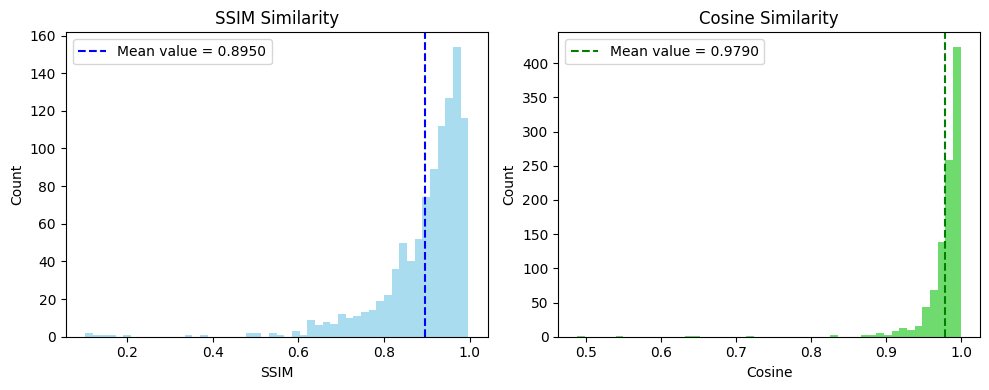

In [ ]:
# Plot SSIM distribution
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].hist(ssim_values_t1, bins=50, alpha=0.7, color='skyblue')
ax[0].axvline(mean_ssim_t1, color='blue', linestyle='--', label=f'Mean value = {mean_ssim_t1:.4f}')
ax[0].set_title("SSIM Similarity")
ax[0].set_xlabel("SSIM")
ax[0].set_ylabel("Count")
ax[0].legend()

ax[1].hist(cosine_values_t1, bins=50, alpha=0.7, color='limegreen')
ax[1].axvline(mean_cos_t1, color='green', linestyle='--', label=f'Mean value = {mean_cos_t1:.4f}')
ax[1].set_title("Cosine Similarity")
ax[1].set_xlabel("Cosine")
ax[1].set_ylabel("Count")
ax[1].legend()

plt.tight_layout()
plt.savefig("images_report/ssim_cosine_t1_1e-3_from_blend")
# plt.show()

### Deblending

In [88]:
def reinit_module_weights(module):
    for layer in module.modules():
        if isinstance(layer, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
            layer.reset_parameters()

def load_vae_weights_but_reset_encoder(vae, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    vae.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded full VAE weights.")
    
    reinit_module_weights(vae.encoder)
    print("Encoder reinitialized.")

torch.manual_seed(28)
vae = VAE(latent_dim=32, beta=1e-3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)

load_vae_weights_but_reset_encoder(vae, "checkpoints/final_vae_checkpoint_iso_clean_beta_1e-3.pth")

Loaded full VAE weights.
Encoder reinitialized.


In [15]:
def train_epoch_deb(vae, device, dataloader, optimizer):
    vae.decoder.eval() # Freeze the decoder
    for param in vae.decoder.parameters():
        param.requires_grad = False
    
    vae.encoder.train()
    
    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0
    
    for blended, _, isolated, _ in dataloader:
        x = blended.to(device)
        x_true = isolated.to(device)
        x_hat, mu, logvar = vae(x)
        loss_dict = vae.loss_function(x_true, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()

        total_loss += loss_dict['loss'].item()
        total_mse += loss_dict['reconstruction_loss'].item()
        total_kl += loss_dict['kl_divergence'].item()
        
    n = len(dataloader.dataset)
    return total_loss / n, total_mse / n, total_kl / n


def test_epoch_deb(vae, device, dataloader, avg_max_vals):
    vae.encoder.eval()
    vae.decoder.eval()

    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0
    plotted = 0

    with torch.no_grad():
        for blended, _, isolated, _ in dataloader:
            x = blended.to(device)
            x_true = isolated.to(device)
            
            x_hat, mu, logvar = vae(x)
            loss_dict = vae.loss_function(x_true, x_hat, mu, logvar)

            total_loss += loss_dict['loss'].item()
            total_mse += loss_dict['reconstruction_loss'].item()
            total_kl += loss_dict['kl_divergence'].item()

            # Plot 3 random reconstructions from this batch
            if plotted < 3:
                fig, axs = plt.subplots(1, 2, figsize=(6, 3))
                i = np.random.randint(0, x_true.shape[0])
                orig = denormalize_non_linear(x_true[i].cpu().numpy() , avg_max_vals)
                recon = denormalize_non_linear(x_hat[i].cpu().numpy() , avg_max_vals)
                mse = np.mean((recon - orig) ** 2)
                mae = np.mean(np.abs(recon - orig))

                axs[0].imshow(orig[4], cmap="viridis")
                axs[0].set_title("Original")
                axs[0].axis("off")

                axs[1].imshow(recon[4], cmap="viridis")
                axs[1].set_title(f"Recon\nMSE:{mse:.2e}\nMAE:{mae:.2e}")
                axs[1].axis("off")

                plt.tight_layout()
                plt.show()

                plotted += 1

    n = len(dataloader.dataset)
    return total_loss / n, total_mse / n, total_kl / n

In [91]:
# --- Training Loop ---
num_epochs = 40
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Reset checkpoint file
checkpoint_path = "checkpoints/final_vae_checkpoint_t2_beta_1e-3.pth"

for epoch in range(num_epochs):
    vae.set_beta(1e-3)
    train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch_deb(vae, device, train_loader, optimizer)
    val_loss[epoch], val_mse[epoch], val_kl[epoch] = test_epoch_deb(vae, device, val_loader, avg_max_vals)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e} | MSE: {train_mse[epoch]:.3e} | KL: {train_kl[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e} | MSE: {val_mse[epoch]:.3e} | KL: {val_kl[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, vae, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1], checkpoint_path)

KeyboardInterrupt: 

In [16]:
vae = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
checkpoint_path = "checkpoints/vae_checkpoint_debvader_1e-3.pth"

epoch, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl = load_checkpoint(vae, optimizer, checkpoint_path) 

Checkpoint loaded from epoch 40


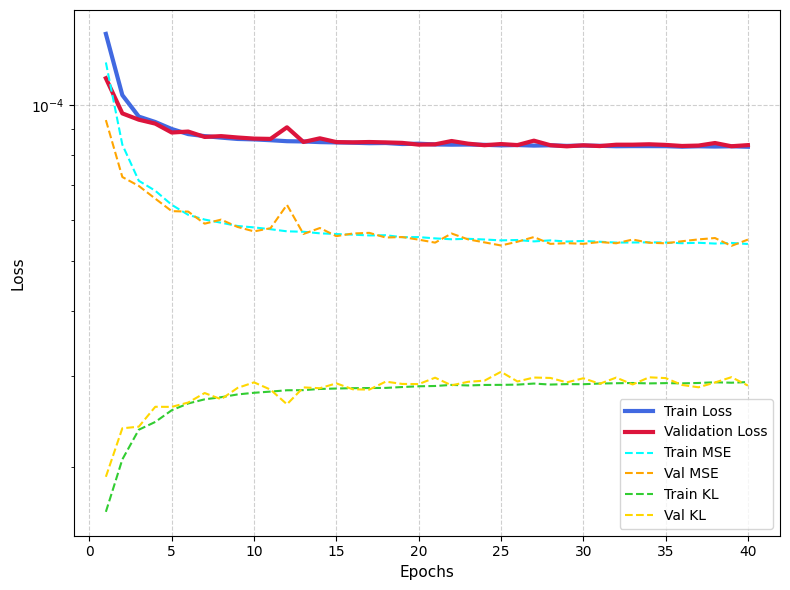

In [107]:
num_epochs = epoch + 1
plot_loss_function(num_epochs, train_loss, train_mse, train_kl * 1e-3, val_loss, val_mse, val_kl * 1e-3, "loss_function_debvader_epoch_1e-3")

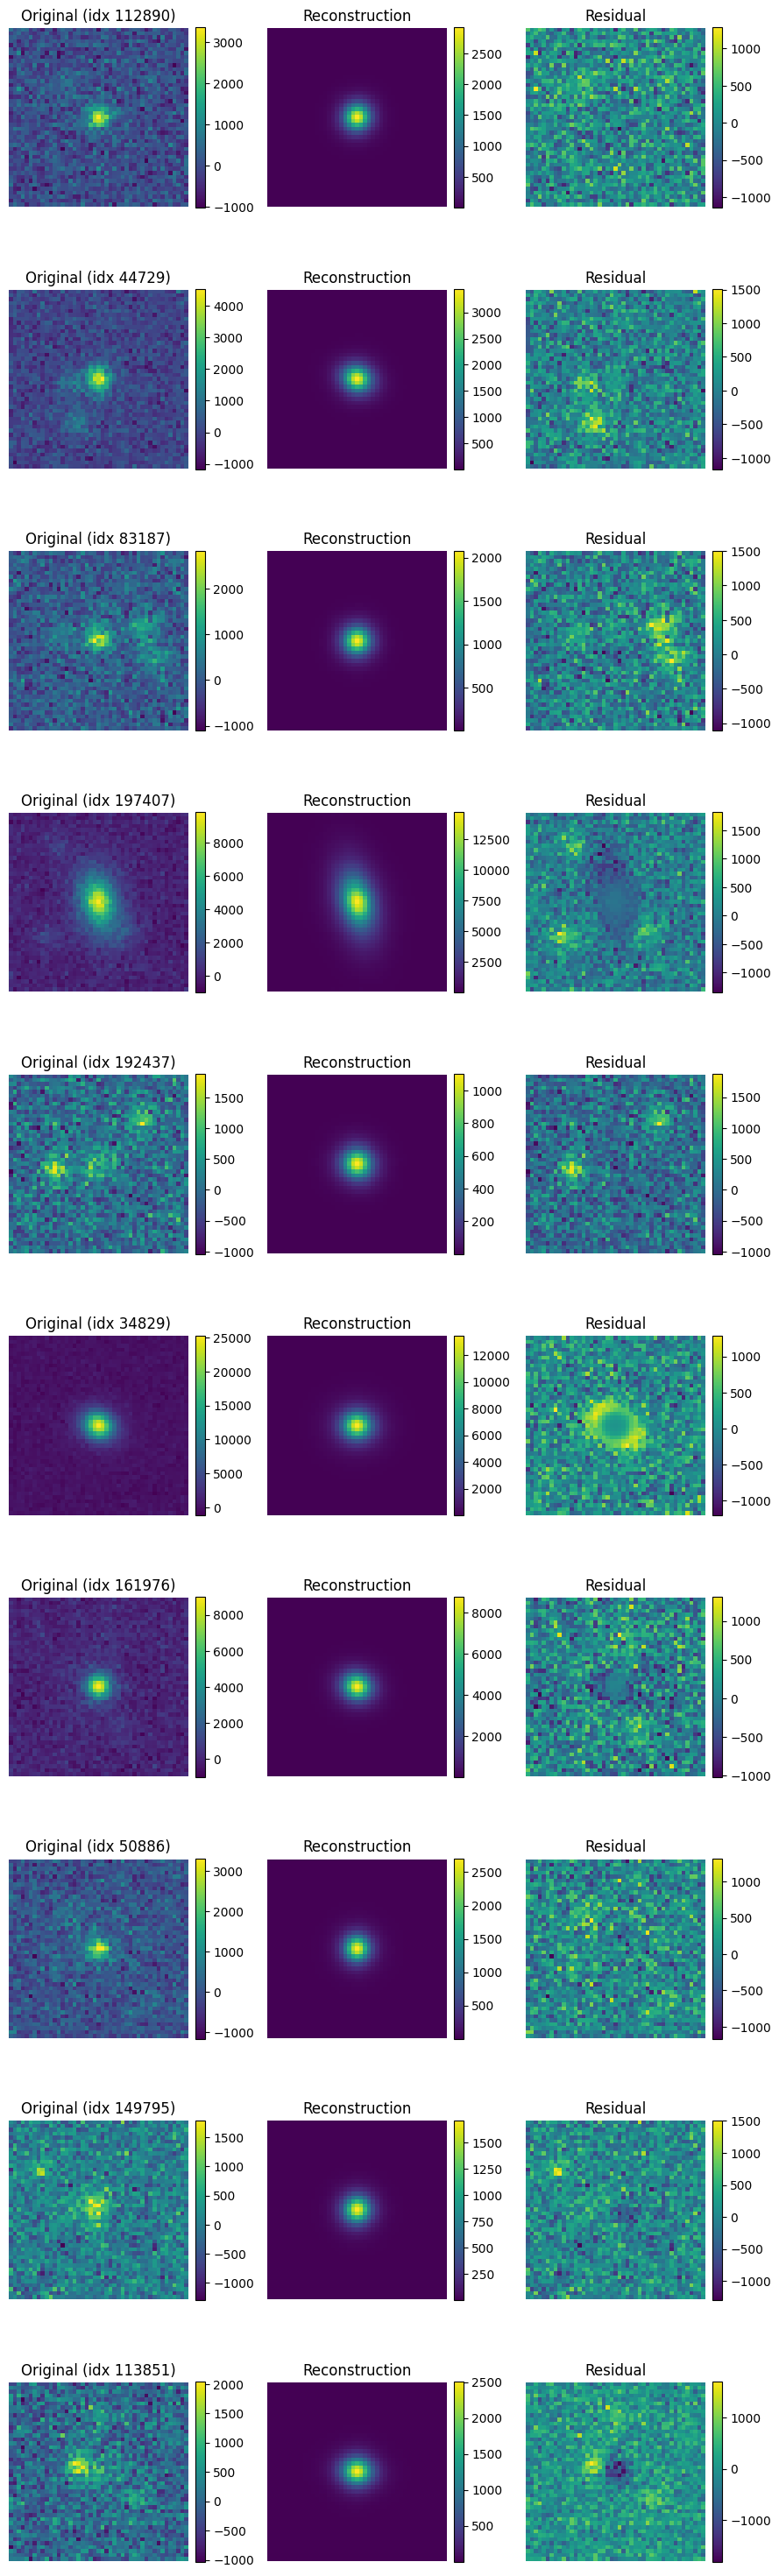

In [113]:
show_random_reconstructions(vae, dataset, device, avg_max_vals, n_samples=10, name="reconstruction_from_blend_debvader_epoch_40_1e-3_2")

In [24]:
ssim_values_t2, cosine_values_t2 = calculate_and_plot_ssim(vae, dataset, device, n_samples=1000, show_images=False)

In [26]:
# Calculate mean
mean_ssim_t2 = np.mean(ssim_values_t2)
mean_cos_t2 = np.mean(cosine_values_t2)

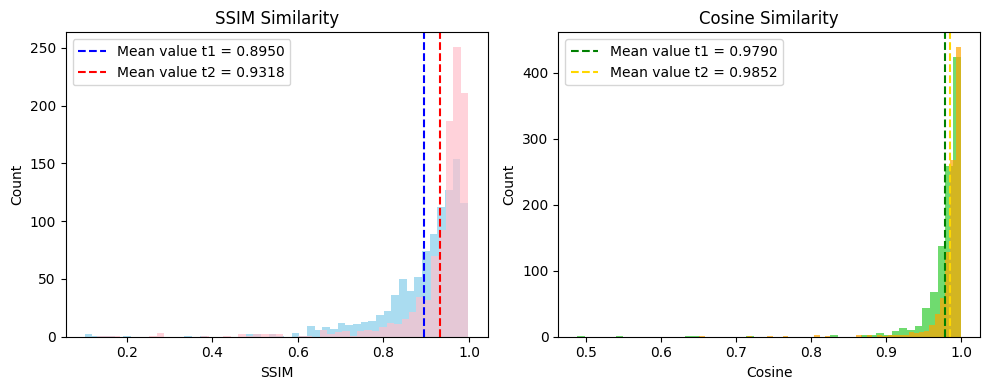

In [33]:
# Plot SSIM distribution
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].hist(ssim_values_t1, bins=50, alpha=0.7, color='skyblue')
ax[0].hist(ssim_values_t2, bins=50, alpha=0.7, color='pink')
ax[0].axvline(mean_ssim_t1, color='blue', linestyle='--', label=f'Mean value t1 = {mean_ssim_t1:.4f}')
ax[0].axvline(mean_ssim_t2, color='red', linestyle='--', label=f'Mean value t2 = {mean_ssim_t2:.4f}')
ax[0].set_title("SSIM Similarity")
ax[0].set_xlabel("SSIM")
ax[0].set_ylabel("Count")
ax[0].legend()

ax[1].hist(cosine_values_t1, bins=50, alpha=0.7, color='limegreen')
ax[1].hist(cosine_values_t2, bins=50, alpha=0.7, color='orange')
ax[1].axvline(mean_cos_t1, color='green', linestyle='--', label=f'Mean value t1 = {mean_cos_t1:.4f}')
ax[1].axvline(mean_cos_t2, color='gold', linestyle='--', label=f'Mean value t2 = {mean_cos_t2:.4f}')
ax[1].set_title("Cosine Similarity")
ax[1].set_xlabel("Cosine")
ax[1].set_ylabel("Count")
ax[1].legend()

plt.tight_layout()
plt.savefig("images_report/ssim_cosine_t2_1e-3_from_blend")
# plt.show()

### Regressor

In [17]:
from matplotlib.patches import Ellipse

In [18]:
# get total size
n = len(dataset)

# subset: first half
half_dataset = Subset(dataset, range(n // 2))

In [20]:
train_size = int(0.9 * len(half_dataset))
val_size = len(half_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(half_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

In [22]:
class LatentRegressorEllipticity(nn.Module):
    def __init__(self, latent_dim=32, output_dim=2):  # output_dim = e1, e2
        super().__init__()
        self.back = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.PReLU(),
            # nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.PReLU(),
            # nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.PReLU()
            )
        self.ellipticity = nn.Sequential(
            nn.Linear(32, 2),
            nn.Tanh() # Output in [-1,1]
        )
    def forward(self, z):
        h = self.back(z)
        e_pred = self.ellipticity(h)
        return e_pred

In [23]:
def train_epoch_reg(vae, device, dataloader, optimizer):
    vae.encoder.eval() # Freeze VAE encoder
    for param in vae.encoder.parameters():
        param.requires_grad = False

    regressor.train()

    train_loss = 0.0
    for blended, iso_noisy, iso_clean, target in dataloader:
        x = blended.to(device)
        target = target.to(device)

        e1_true = target[:, 1]
        e2_true = target[:, 2]

        with torch.no_grad():
            mu, _ = vae.encoder(x)

        e_pred = regressor(mu)
        e1_pred = e_pred[:,0]
        e2_pred = e_pred[:,1]

        # Loss function
        loss_e1 = F.mse_loss(e1_pred, e1_true,reduction="mean")
        loss_e2 = F.mse_loss(e2_pred, e2_true,reduction="mean")

        loss = loss_e1 + loss_e2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    n = len(dataloader.dataset)
    return train_loss / n

def val_epoch_reg(vae, device, dataloader):
    vae.encoder.eval()
    for param in vae.encoder.parameters():
        param.requires_grad = False

    regressor.eval()
    
    val_loss = 0.0
    with torch.no_grad():
        for blended, iso_noisy, iso_clean, target in dataloader:
            x = blended.to(device)
            target = target.to(device)
            
            e1_true = target[:, 1]
            e2_true = target[:, 2]

            mu, _ = vae.encoder(x)

            e_pred = regressor(mu)
            e1_pred = e_pred[:,0]
            e2_pred = e_pred[:,1]
            
            # Loss function
            loss_e1 = F.mse_loss(e1_pred, e1_true,reduction="mean")
            loss_e2 = F.mse_loss(e2_pred, e2_true,reduction="mean")

            loss = loss_e1 + loss_e2

            val_loss += loss.item()

    n = len(dataloader.dataset)
    return val_loss / n

In [41]:
regressor = LatentRegressorEllipticity(latent_dim=32).to(device)
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)

# --- Training Loop ---
num_epochs = 100
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Reset checkpoint file
checkpoint_path = "checkpoints/final_regressor_checkpoint_3.pth"

for epoch in range(num_epochs):
    print("Training ...")
    train_loss[epoch] = train_epoch_reg(vae, device, train_loader, optimizer)
    print("Evaluating ...")
    val_loss[epoch] = val_epoch_reg(vae, device, val_loader)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, regressor, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1], checkpoint_path=checkpoint_path)

Training ...
Evaluating ...

EPOCH 1/100
Train Loss: 1.007e-04
Val   Loss: 9.063e-05
Training ...


KeyboardInterrupt: 

In [26]:
regressor = LatentRegressorEllipticity(latent_dim=32).to(device)
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)

checkpoint_path = "checkpoints/final_regressor_checkpoint_2.pth"
num_epochs, train_loss, _, _, val_loss,_, _ = load_checkpoint(regressor, optimizer, checkpoint_path)

Checkpoint loaded from epoch 50


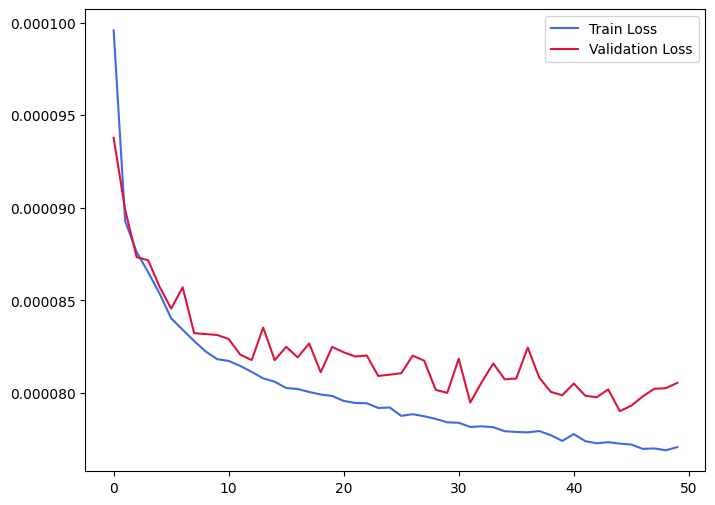

In [27]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

epochs = np.arange(0, num_epochs + 1)

# Train Loss Plot
ax.plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-")
ax.plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-")
ax.legend()
plt.show()

In [28]:
def show_random_reconstructions(vae, regressor, dataset, device, avg_max_vals, n_samples=5, name="test"):
    vae.eval()
    regressor.eval()

    fig, axs = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))

    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx][0].unsqueeze(0).to(device)
        z_true, e1_true, e2_true = dataset[idx][3]
        e1_true = e1_true.cpu().numpy()
        e2_true = e2_true.cpu().numpy()

        with torch.no_grad():
            recon, mu, _ = vae(img)
            pred_e = regressor(mu)
            pred_e1, pred_e2 = pred_e.squeeze().cpu().numpy()
        
        img_ = denormalize_non_linear(img.squeeze().cpu().numpy(), avg_max_vals)
        recon_ = denormalize_non_linear(recon.squeeze().cpu().numpy(), avg_max_vals)
        band = 2

        de1 = (pred_e1 - e1_true)
        de2 = (pred_e2 - e2_true)

        # Plot original
        axs[i, 0].imshow(img_[band], cmap='viridis')
        axs[i, 0].set_title(f"Original\ne1={e1_true:.3f}, e2={e2_true:.3f}")
        axs[i, 0].axis('off')
        draw_ellipticity(axs[i,0], [22, 22], e1_true, e2_true)

        # Plot reconstruction
        axs[i, 1].imshow(recon_[band], cmap='viridis')
        axs[i, 1].set_title(f"Reconstructed\ne1={pred_e1:.3f}, e2={pred_e2:.3f}")
        axs[i, 1].axis('off')
        draw_ellipticity(axs[i,1], [22, 22], e1_true, e2_true)
        draw_ellipticity(axs[i,1], [22, 22], pred_e1, pred_e2, color='gold')

        # Plot residual
        axs[i, 2].imshow(img_[band] - recon_[band], cmap='viridis')
        axs[i, 2].set_title(f"Residual\n$\Delta$e1={de1:.3f}, $\Delta$e2={de2:.3f}")
        axs[i, 2].axis('off')

    plt.tight_layout()
    # plt.savefig(f"images/{name}")
    plt.show()

In [29]:
def draw_ellipticity(ax, centroid, e1, e2, scale=20, color='red'):
    # Convert (e1, e2) to ellipticity magnitude and orientation
    e = np.sqrt(e1**2 + e2**2)
    if e > 1:
        e = 1  # limit for physical interpretation
    
    theta = 0.5 * np.arctan2(e2, e1)  # orientation in radians
    width = scale * (1 + e)
    height = scale * (1 - e)

    ellipse = Ellipse(xy=centroid, width=width, height=height,
                      angle=np.degrees(theta), edgecolor=color,
                      facecolor='none', lw=2)
    ax.add_patch(ellipse)

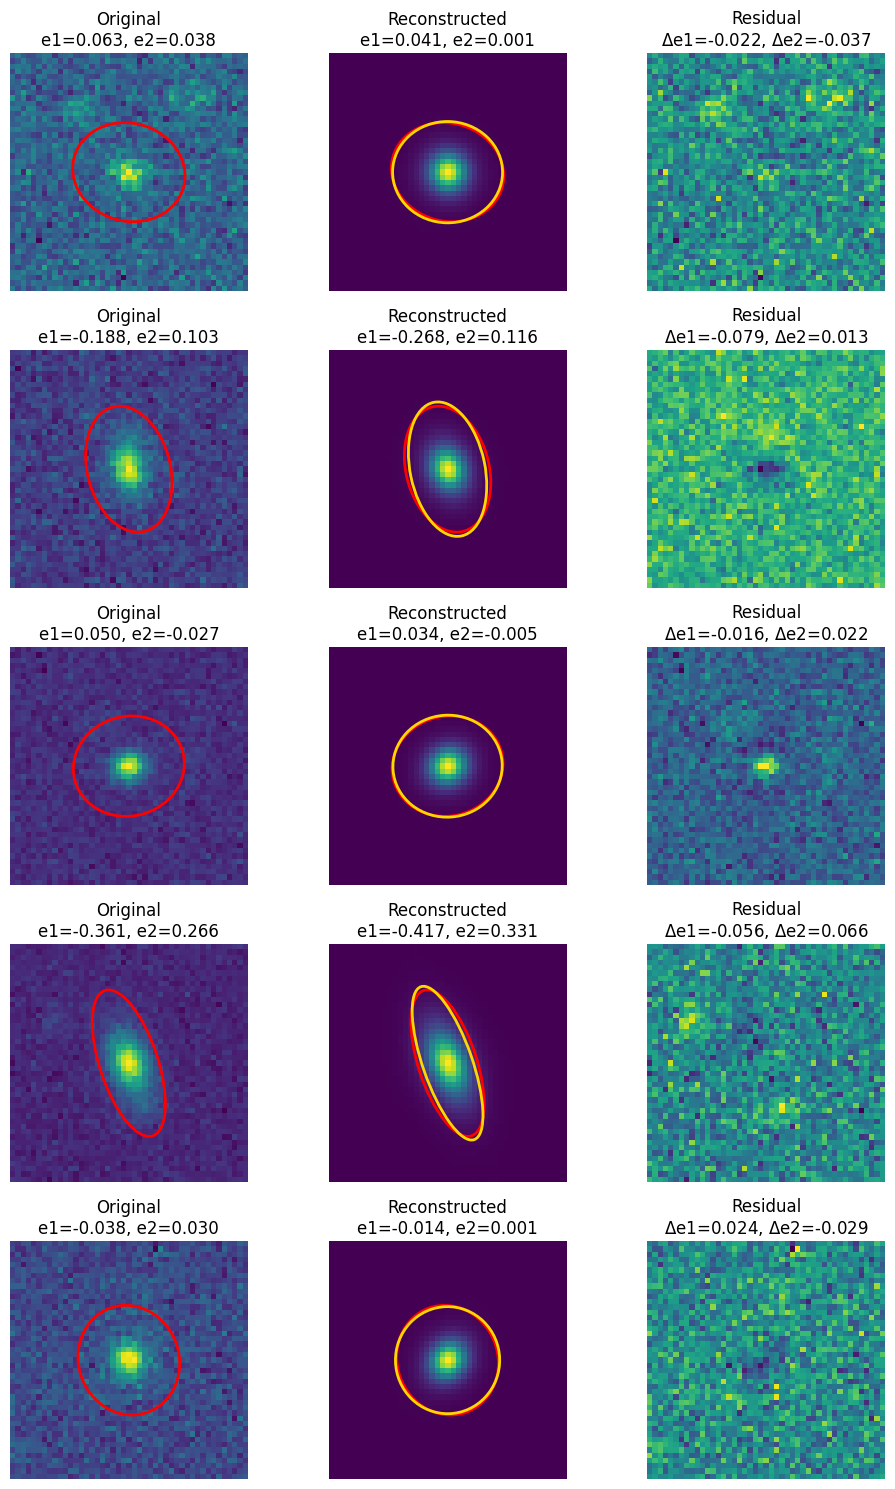

In [30]:
show_random_reconstructions(vae, regressor, val_dataset, device, avg_max_vals, n_samples=5, name="regressor_no_filtered_1_0")

In [31]:
def calculate_ellipticity(image, centroids):
    y, x = np.indices(image.shape)
    x_center = centroids[0]
    y_center = centroids[1]
    Qxx = np.sum((x - x_center)**2 * image)
    Qyy = np.sum((y - y_center)**2 * image)
    Qxy = np.sum((x - x_center) * (y - y_center) * image)
    e1 = (Qxx - Qyy) / (Qxx + Qyy)
    e2 = (2 * Qxy) / (Qxx + Qyy)
    return e1, e2

In [33]:
def get_ellipticity_arrays(vae, regressor, dataset, device, avg_max_vals, n_samples=100):
    vae.eval()
    regressor.eval()

    e1_recon_list = []
    e2_recon_list = []
    e1_pred_list = []
    e2_pred_list = []
    e1_true_list = []
    e2_true_list = []

    for _ in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx][0].unsqueeze(0).to(device)
        z_true, e1_true, e2_true = dataset[idx][3]

        with torch.no_grad():
            recon, mu, _ = vae(img)
            pred_e = regressor(mu)
            pred_e1, pred_e2 = pred_e.squeeze().cpu().numpy()

        # Get reconstructed image and denormalize
        recon_img = recon.squeeze().cpu().numpy()
        recon_img = denormalize_non_linear(recon_img, avg_max_vals)
        band = 2  # third channel
        recon_band = recon_img[band]

        # Compute ellipticity from reconstructed image
        e1_recon, e2_recon = calculate_ellipticity(recon_band, centroids=[22, 22])

        # Store all values
        e1_recon_list.append(e1_recon)
        e2_recon_list.append(e2_recon)
        e1_pred_list.append(pred_e1)
        e2_pred_list.append(pred_e2)
        e1_true_list.append(e1_true.item())
        e2_true_list.append(e2_true.item())

    return (
        np.array(e1_recon_list),
        np.array(e2_recon_list),
        np.array(e1_pred_list),
        np.array(e2_pred_list),
        np.array(e1_true_list),
        np.array(e2_true_list)
    )

In [34]:
e1_recon, e2_recon, e1_pred, e2_pred, e1_true, e2_true = get_ellipticity_arrays(vae, regressor, val_dataset, device, avg_max_vals, n_samples=5000)

In [35]:
import corner
import seaborn as sns

In [39]:
de1_recon = e1_recon - e1_true
de2_recon = e2_recon - e2_true

de1_pred = e1_pred - e1_true
de2_pred = e2_pred - e2_true

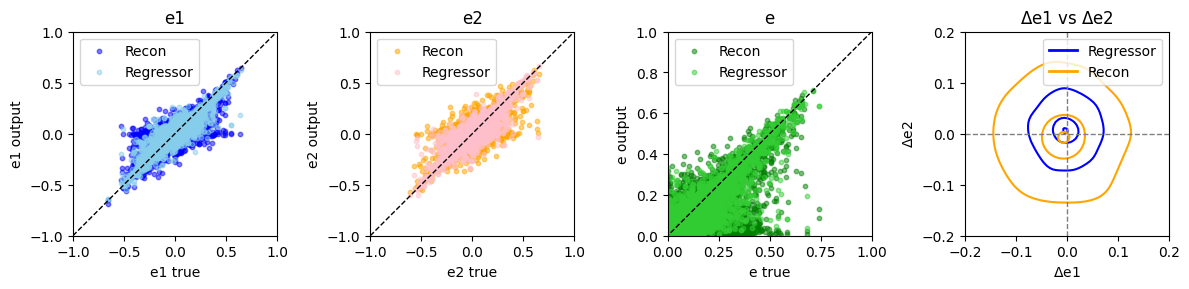

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

# Plot e1 scatter (true vs recon and pred)
ax[0].scatter(e1_true, e1_recon, label="Recon", alpha=0.5, s=10, color='blue')
ax[0].scatter(e1_true, e1_pred, label="Regressor", alpha=0.5, s=10, color='skyblue')
ax[0].plot([-1, 1], [-1, 1], 'k--', linewidth=1)  # Diagonal line
ax[0].set_title("e1")
ax[0].set_xlabel("e1 true")
ax[0].set_ylabel("e1 output")
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].set_aspect('equal')
ax[0].legend()

# Plot e2 scatter (true vs recon and pred)
ax[1].scatter(e2_true, e2_recon, label="Recon", alpha=0.5, s=10, color='orange')
ax[1].scatter(e2_true, e2_pred, label="Regressor", alpha=0.5, s=10, color='pink')
ax[1].plot([-1, 1], [-1, 1], 'k--', linewidth=1)  # Diagonal line
ax[1].set_title("e2")
ax[1].set_xlabel("e2 true")
ax[1].set_ylabel("e2 output")
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_aspect('equal')
ax[1].legend()

e_recon = np.sqrt(e1_recon**2 + e2_recon**2)
e_pred = np.sqrt(e1_pred**2 + e2_pred**2)
e_true = np.sqrt(e1_true**2 + e2_true**2)

ax[2].scatter(e_true, e_recon, label="Recon", alpha=0.5, s=10, color='green')
ax[2].scatter(e_true, e_pred, label="Regressor", alpha=0.5, s=10, color='limegreen')
ax[2].plot([-1, 1], [-1, 1], 'k--', linewidth=1)  # Diagonal line
ax[2].set_title("e")
ax[2].set_xlabel("e true")
ax[2].set_ylabel("e output")
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)
ax[2].set_aspect('equal')
ax[2].legend()

# KDE contours of residuals
sns.kdeplot(x=de1_pred, y=de2_pred, ax=ax[3], levels=[0.393, 0.865, 0.989], linewidths=1.5, color='blue')
sns.kdeplot(x=de1_recon, y=de2_recon, ax=ax[3], levels=[0.393, 0.865, 0.989], linewidths=1.5, color='orange')
ax[3].set_xlim(-0.2, 0.2)
ax[3].set_ylim(-0.2, 0.2)
ax[3].set_aspect('equal')
ax[3].axhline(0, color='gray', linestyle='--', linewidth=1)
ax[3].axvline(0, color='gray', linestyle='--', linewidth=1)
ax[3].set_xlabel(r"$\Delta$e1")
ax[3].set_ylabel(r"$\Delta$e2")

# Manual legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Regressor'),
    Line2D([0], [0], color='orange', lw=2, label='Recon')
]
ax[3].legend(handles=legend_elements)
ax[3].set_title(r"$\Delta$e1 vs $\Delta$e2")

plt.tight_layout()
plt.savefig("images_report/ellipticities_lsst_no_drop_out")
plt.show()

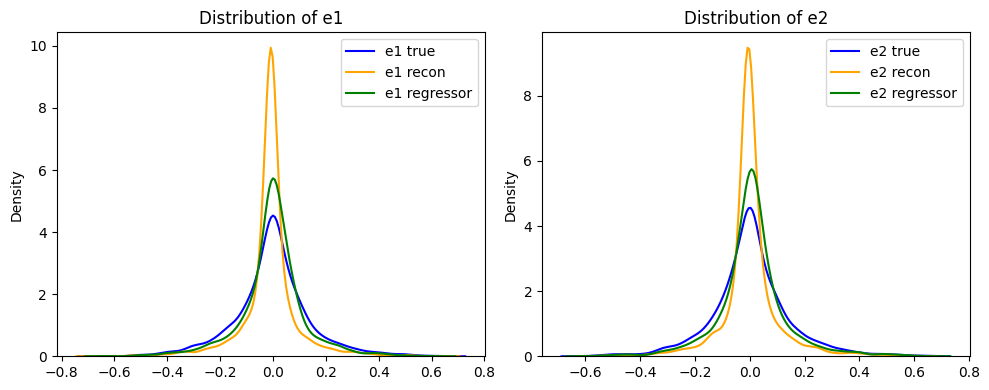

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(e1_true, ax=ax[0], label="e1 true", color='blue')
sns.kdeplot(e1_recon, ax=ax[0], label="e1 recon", color='orange')
sns.kdeplot(e1_pred, ax=ax[0], label="e1 regressor", color='green')

sns.kdeplot(e2_true, ax=ax[1], label="e2 true", color='blue')
sns.kdeplot(e2_recon, ax=ax[1], label="e2 recon", color='orange')
sns.kdeplot(e2_pred, ax=ax[1], label="e2 regressor", color='green')

for a, title in zip(ax, ["e1", "e2"]):
    a.set_title(f"Distribution of {title}")
    a.legend()

plt.tight_layout()
plt.savefig("images/distribution_e1_e2_no_drop_out")

In [35]:
from sklearn.metrics import mean_squared_error

rmse = lambda x: np.sqrt(mean_squared_error(x, np.zeros_like(x)))

print("Reconstruction RMSE: e1 =", rmse(de1_recon), ", e2 =", rmse(de2_recon))
print("Regressor RMSE:      e1 =", rmse(de1_pred),  ", e2 =", rmse(de2_pred))

Reconstruction RMSE: e1 = 0.11025073521922976 , e2 = 0.11165898935962595
Regressor RMSE:      e1 = 0.07323479467878861 , e2 = 0.07639606855776573


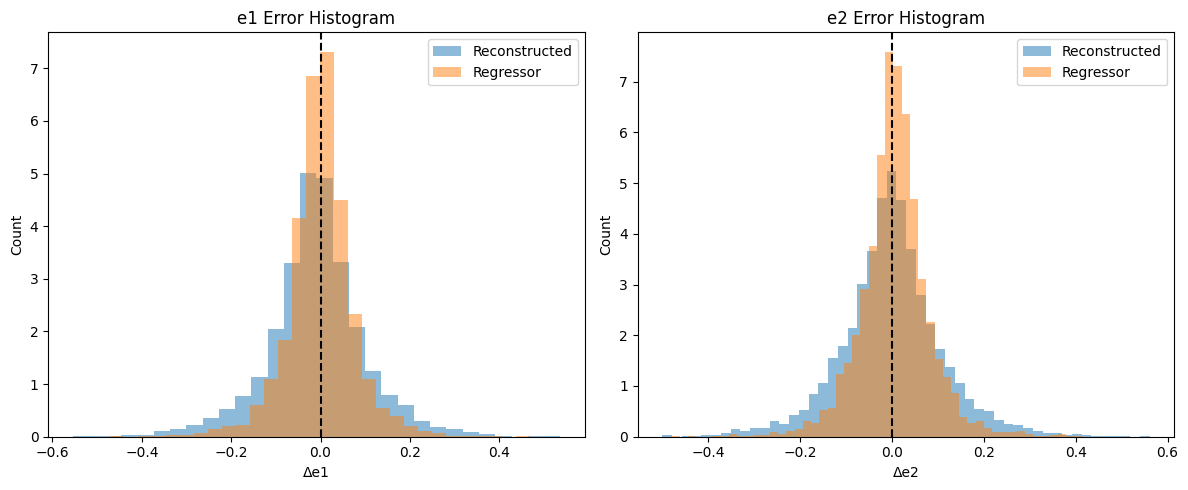

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(de1_recon, bins=30, alpha=0.5, label='Reconstructed', density=True)
plt.hist(de1_pred,  bins=30, alpha=0.5, label='Regressor', density=True)
plt.axvline(0, color='black', linestyle='--')
plt.title("e1 Error Histogram")
plt.xlabel("Δe1")
plt.ylabel("Count")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(de2_recon, bins=50, alpha=0.5, label='Reconstructed', density=True)
plt.hist(de2_pred,  bins=50, alpha=0.5, label='Regressor', density=True)
plt.axvline(0, color='black', linestyle='--')
plt.title("e2 Error Histogram")
plt.xlabel("Δe2")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.savefig("images/e1_e2_errors_histo")

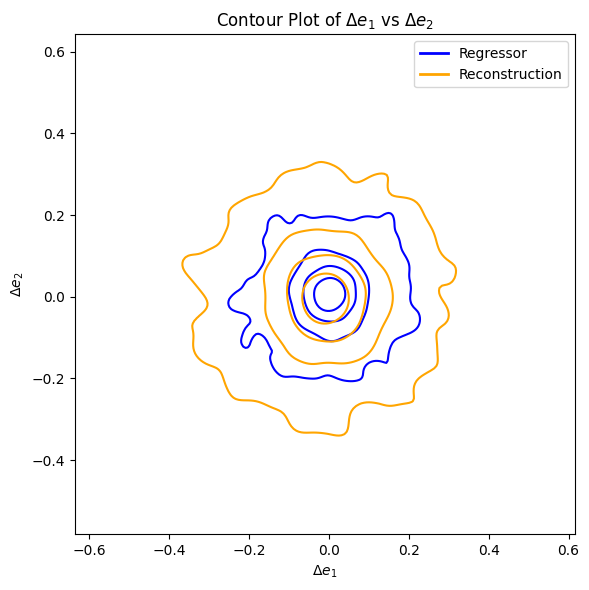

In [37]:
# Plot
plt.figure(figsize=(6, 6))

# Plot both contours
line1 = sns.kdeplot(
    x=de1_pred, y=de2_pred,
    levels=5, linewidths=1.5,
    color='blue'
)
line2 = sns.kdeplot(
    x=de1_recon, y=de2_recon,
    levels=5, linewidths=1.5,
    color='orange'
)

# Add legend manually
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Regressor'),
    Line2D([0], [0], color='orange', lw=2, label='Reconstruction')
]
plt.legend(handles=legend_elements)

# Formatting
# plt.axhline(0, color='gray', linestyle='--')
# plt.axvline(0, color='gray', linestyle='--')
plt.xlabel(r"$\Delta e_1$")
plt.ylabel(r"$\Delta e_2$")
plt.title(r"Contour Plot of $\Delta e_1$ vs $\Delta e_2$")
plt.tight_layout()
plt.savefig("images/e1_e2_error_contour_no_filtered")

### DES

In [51]:
import pandas as pd

In [52]:
des_im3shape = pd.read_csv("../des_sva1_im3shape_ellipticity.csv")

folder_path = "../data/des_data/blended_training_data"
npy_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
names_int = [int(os.path.splitext(f)[0]) for f in npy_files]

# Load and stack
data_list = []
for file in npy_files:
    data = np.load(os.path.join(folder_path, file))
    data_list.append(data)

stacked_array = np.stack(data_list)
des_im3shape_f = des_im3shape[des_im3shape['coadd_objects_id'].isin(names_int)]

In [53]:
# Convert 'coadd_objects_id' to a categorical variable with the order of 'names_int'
des_im3shape_f['coadd_objects_id'] = pd.Categorical(
    des_im3shape_f['coadd_objects_id'],
    categories=names_int,
    ordered=True
)

# Sort the DataFrame by 'coadd_objects_id' to match 'names_int' order
des_im3shape_f_sorted = des_im3shape_f.sort_values('coadd_objects_id')

# Now extract e1 and e2 in the correct order
e1 = des_im3shape_f_sorted['e_1'].values
e2 = des_im3shape_f_sorted['e_2'].values

/var/folders/5l/n_734vm55ybclgjt5hyn9xmr0000gp/T/ipykernel_15154/1335041039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  des_im3shape_f['coadd_objects_id'] = pd.Categorical(


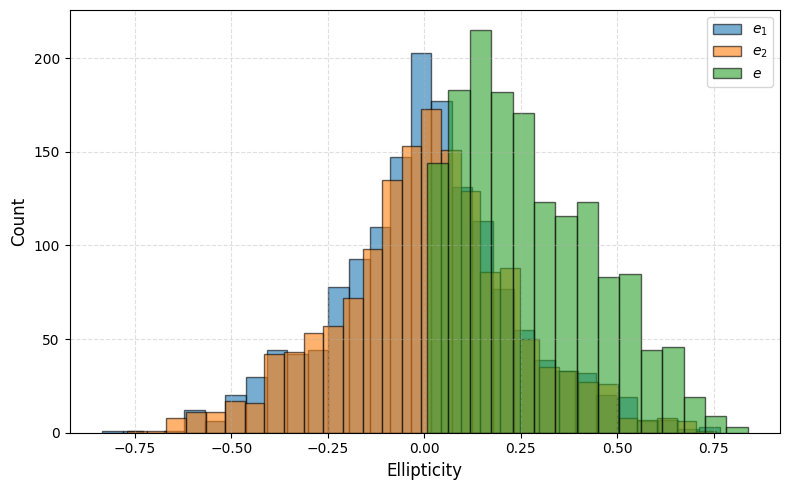

In [116]:
fig, ax = plt.subplots(figsize=(8, 5))

e1 = des_im3shape_f['e_1']
e2 = -des_im3shape_f['e_2']
e = np.sqrt(e1**2 + e2**2)

# Plot histograms with better style
ax.hist(e1, bins=30, alpha=0.6, label=r"$e_1$", color='tab:blue', edgecolor='black')
ax.hist(e2, bins=30, alpha=0.6, label=r"$e_2$", color='tab:orange', edgecolor='black')
ax.hist(e, bins=15, alpha=0.6, label=r"$e$", color='tab:green', edgecolor='black')

# Labels and legend
ax.set_xlabel("Ellipticity", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("images_report/ellipticity_des")

In [85]:
max_vals = np.max(stacked_array, axis=(2,3))
avg_max_vals_des = np.mean(max_vals, axis=0)

norm_des = normalize_non_linear(stacked_array, avg_max_vals_des)
norm_lsst = dataset.blend_imgs[:5000]

In [86]:
band_names = ['u', 'g', 'r', 'i', 'z', 'Y']

lsst_flat = {}
des_flat = {}

for band in band_names:
    lsst_flat[band] = np.hstack([
        norm_lsst[k][band_names.index(band)].ravel() 
        for k in range(norm_lsst.shape[0])
    ])
    
    if band != 'u':  # Skip 'u' for DES
        des_flat[band] = np.hstack([
            norm_des[k][band_names.index(band)-1].ravel() 
            for k in range(norm_des.shape[0])
        ])
    else:
        des_flat[band] = None  # Mark as missing

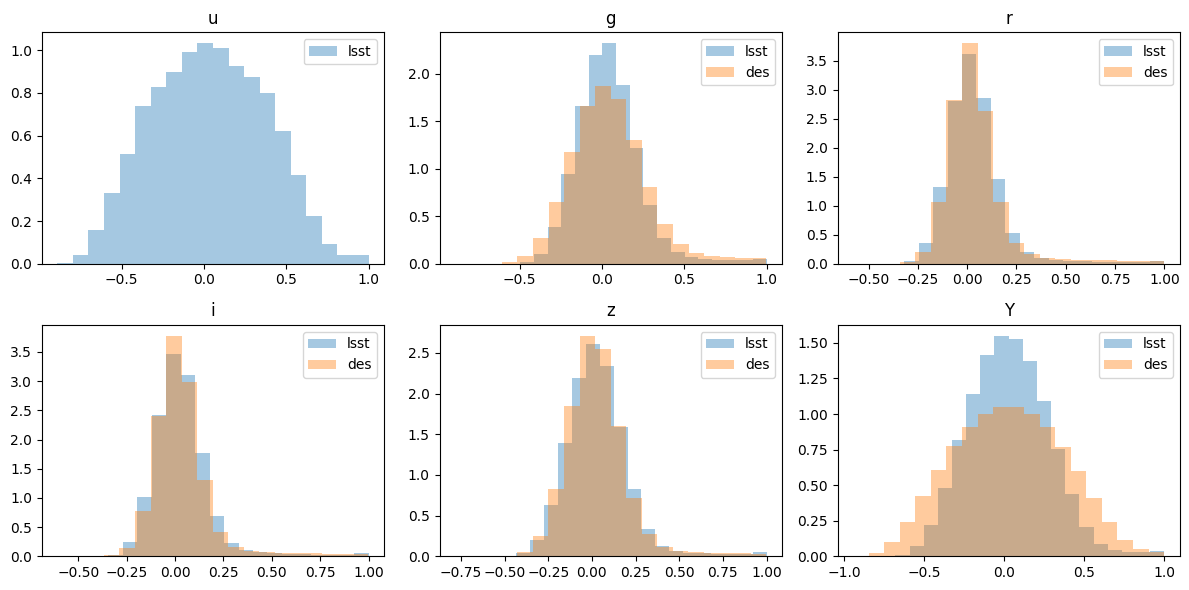

In [87]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
ax[0, 0].hist(lsst_flat['u'], bins=20, alpha=0.4, label="lsst", density=True)
ax[0, 0].set_title("u")
ax[0, 0].legend()

ax[0, 1].hist(lsst_flat['g'], bins=20, alpha=0.4, label="lsst", density=True)
ax[0, 1].hist(des_flat['g'], bins=20, alpha=0.4, label="des", density=True)
ax[0, 1].set_title("g")
ax[0, 1].legend()

ax[0, 2].hist(lsst_flat['r'], bins=20, alpha=0.4, label="lsst", density=True)
ax[0, 2].hist(des_flat['r'], bins=20, alpha=0.4, label="des", density=True)
ax[0, 2].set_title("r")
ax[0, 2].legend()

ax[1, 0].hist(lsst_flat['i'], bins=20, alpha=0.4, label="lsst", density=True)
ax[1, 0].hist(des_flat['i'], bins=20, alpha=0.4, label="des", density=True)
ax[1, 0].set_title("i")
ax[1, 0].legend()

ax[1, 1].hist(lsst_flat['z'], bins=20, alpha=0.4, label="lsst", density=True)
ax[1, 1].hist(des_flat['z'], bins=20, alpha=0.4, label="des", density=True)
ax[1, 1].set_title("z")
ax[1, 1].legend()

ax[1, 2].hist(lsst_flat['Y'], bins=20, alpha=0.4, label="lsst", density=True)
ax[1, 2].hist(des_flat['Y'], bins=20, alpha=0.4, label="des", density=True)
ax[1, 2].set_title("Y")
ax[1, 2].legend()

plt.tight_layout()
# plt.savefig("images/dynamical_range")

In [88]:
norm_des_ = np.concatenate((np.zeros(shape=(1546, 1, 45, 45)), norm_des), axis=1)
norm_des_ = torch.from_numpy(norm_des_).float()

In [89]:
avg_max_vals_des = np.insert(avg_max_vals_des, 0, 0)

In [90]:
avg_max_vals_des

array([  0.      ,  30.194494,  86.35717 , 154.06761 , 227.15562 ,
       252.79266 ], dtype=float32)

/var/folders/5l/n_734vm55ybclgjt5hyn9xmr0000gp/T/ipykernel_15154/3193383021.py:9: RuntimeWarning: invalid value encountered in arctanh
  unscaled = np.sinh(np.arctanh(images_normed))


<function matplotlib.pyplot.show(close=None, block=None)>

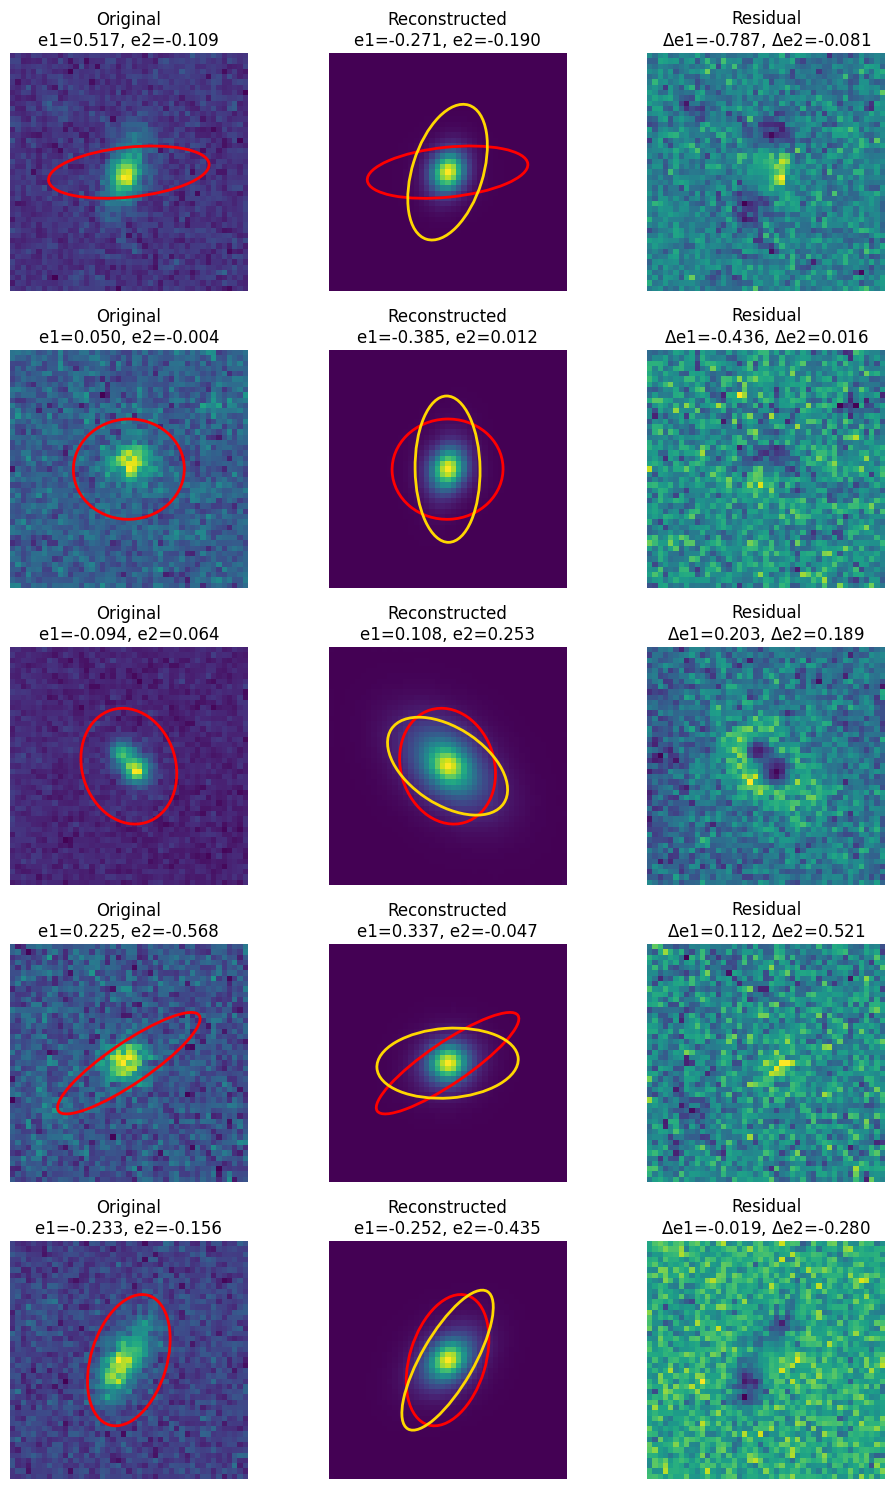

In [114]:
vae.eval()
regressor.eval()

n_samples = 5
fig, axs = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))
band = 2 # r-band

for i in range(n_samples):
    idx = np.random.randint(0, len(norm_des_))
    img = norm_des_[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        recon, mu, _ = vae(img)
        pred_e = regressor(mu)
        pred_e1, pred_e2 = pred_e.squeeze().cpu().numpy()
    
    img_ = denormalize_non_linear(img.squeeze().cpu().numpy(), avg_max_vals_des)
    recon_ = denormalize_non_linear(recon.squeeze().cpu().numpy(), avg_max_vals_des)
    res = recon.squeeze().cpu().numpy() - img.squeeze().cpu().numpy()
    res_ = denormalize_non_linear(res, avg_max_vals_des)
    
    de1 = (pred_e1 - e1[idx])
    de2 = (pred_e2 - e2[idx])

    # Plot original
    axs[i, 0].imshow(img_[band], cmap='viridis')
    axs[i, 0].set_title(f"Original\ne1={e1[idx]:.3f}, e2={e2[idx]:.3f}")
    axs[i, 0].axis('off')
    draw_ellipticity(axs[i,0], [22, 22], e1[idx], e2[idx])

    # Plot reconstruction
    axs[i, 1].imshow(recon_[band], cmap='viridis')
    axs[i, 1].set_title(f"Reconstructed\ne1={pred_e1:.3f}, e2={pred_e2:.3f}")
    axs[i, 1].axis('off')
    draw_ellipticity(axs[i,1], [22, 22], e1[idx], e2[idx])
    draw_ellipticity(axs[i,1], [22, 22], pred_e1, pred_e2, color='gold')

    # Plot residual
    axs[i, 2].imshow(res_[band], cmap='viridis')
    axs[i, 2].set_title(f"Residual\n$\Delta$e1={de1:.3f}, $\Delta$e2={de2:.3f}")
    axs[i, 2].axis('off')

plt.tight_layout()
# plt.savefig(f"images/{name}")
plt.show

In [2]:
vae.eval()
regressor.eval()

e1_recon_list = []
e2_recon_list = []
e1_pred_list = []
e2_pred_list = []
e1_true_list = []
e2_true_list = []

band = 2  # r band
n_samples = 5000
for _ in range(n_samples):
    idx = np.random.randint(0, len(norm_des_))
    img = norm_des_[idx].unsqueeze(0).to(device)

    with torch.no_grad():
        recon, mu, _ = vae(img)
        pred_e = regressor(mu)
        pred_e1, pred_e2 = pred_e.squeeze().cpu().numpy()
    
    img_ = denormalize_non_linear(img.squeeze().cpu().numpy(), avg_max_vals_des)
    recon_ = denormalize_non_linear(recon.squeeze().cpu().numpy(), avg_max_vals_des)
    res = recon.squeeze().cpu().numpy() - img.squeeze().cpu().numpy()
    res_ = denormalize_non_linear(res, avg_max_vals_des)
    
    # Compute ellipticity from reconstructed image
    e1_recon, e2_recon = calculate_ellipticity(recon_[band], centroids=[22, 22])

    # Store all values
    e1_recon_list.append(e1_recon)
    e2_recon_list.append(e2_recon)
    e1_pred_list.append(pred_e1)
    e2_pred_list.append(pred_e2)
    e1_true_list.append(e1[idx])
    e2_true_list.append(e2[idx])

NameError: name 'vae' is not defined

In [1]:
de1_recon = e1_recon_list - e1_true_list
de2_recon = e2_recon_list - e2_true_list

de1_pred = e1_pred_list - e1_true_list
de2_pred = e2_pred_list - e2_true_list

NameError: name 'e1_recon_list' is not defined